# Phase 1: Data Foundation & Exploration

In [ ]:
# Cell 1: Environment Setup and Library Installation
!pip install transformers datasets torch scikit-learn pandas seaborn wandb kagglehub -q

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cell 2: Essential Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import gc

# Set random seeds for reproducibility
np.random.seed(42)
import torch
torch.manual_seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Environment setup completed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Environment setup completed successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True


In [ ]:
# Cell 3: Dataset Download and Path Configuration
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print("Path to dataset files:", path)

# Define local paths for data processing
LOCAL_RAW_DATA_PATH = f'{path}/Resume/Resume.csv'
LOCAL_PROCESSED_DATA_PATH = '/content/resume_processed.csv'
LOCAL_TRAIN_DATA_PATH = '/content/resume_train.csv'
LOCAL_VAL_DATA_PATH = '/content/resume_val.csv'
LOCAL_TEST_DATA_PATH = '/content/resume_test.csv'
LOCAL_STATS_PATH = '/content/data_exploration_stats.txt'

print("✅ Dataset download and path configuration completed!")

Path to dataset files: /kaggle/input/resume-dataset
✅ Dataset download and path configuration completed!


In [ ]:
# Cell 4: Initial Data Loading and Structure Analysis
# Load the dataset
df_raw = pd.read_csv(LOCAL_RAW_DATA_PATH)

print("=== DATASET STRUCTURE ANALYSIS ===")
print(f"Dataset shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print(f"Data types:\n{df_raw.dtypes}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print("\n=== SAMPLE DATA ===")
display(df_raw.head())

# Basic info
print("\n=== DATASET INFO ===")
df_raw.info()

=== DATASET STRUCTURE ANALYSIS ===
Dataset shape: (2484, 4)
Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']
Data types:
ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object
Memory usage: 86.11 MB

=== SAMPLE DATA ===


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR



=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


=== ORIGINAL CATEGORY DISTRIBUTION ===
Total categories: 24
Total resumes: 2484

Category distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


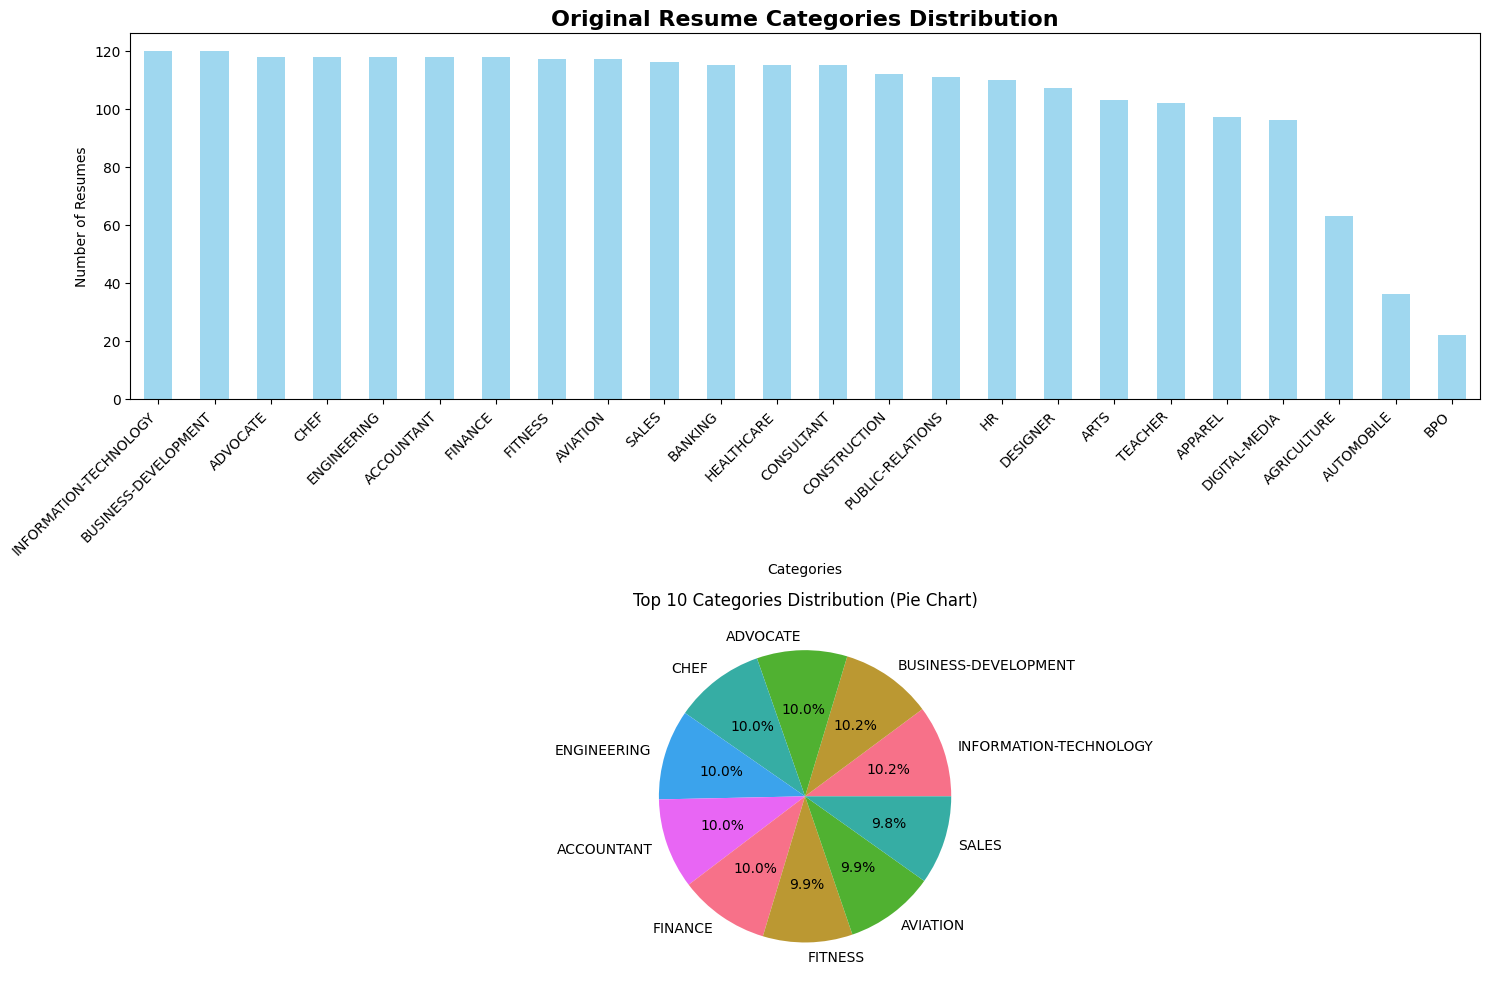

In [ ]:
# Cell 5: Category Distribution Analysis
print("=== ORIGINAL CATEGORY DISTRIBUTION ===")
category_counts = df_raw['Category'].value_counts()
print(f"Total categories: {len(category_counts)}")
print(f"Total resumes: {len(df_raw)}")
print("\nCategory distribution:")
print(category_counts)

# Visualize category distribution
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
category_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Original Resume Categories Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.pie(category_counts.head(10).values, labels=category_counts.head(10).index, autopct='%1.1f%%')
plt.title('Top 10 Categories Distribution (Pie Chart)')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6: Department Mapping Strategy Definition (Fixed)
# Define mapping from 24 actual categories to 7 target departments
DEPARTMENT_MAPPING = {
    # IT Department
    'INFORMATION-TECHNOLOGY': 'IT',
    'BPO': 'IT',  # Business Process Outsourcing often IT-related
    'DIGITAL-MEDIA': 'IT',  # Digital media often requires tech skills

    # Engineering Department
    'ENGINEERING': 'Engineering',
    'CONSTRUCTION': 'Engineering',
    'AUTOMOBILE': 'Engineering',
    'AVIATION': 'Engineering',
    'AGRICULTURE': 'Engineering',  # Agricultural engineering/science

    # Healthcare Department
    'HEALTHCARE': 'Healthcare',
    'FITNESS': 'Healthcare',

    # Finance Department
    'FINANCE': 'Finance',
    'BANKING': 'Finance',
    'ACCOUNTANT': 'Finance',

    # Marketing Department
    'DESIGNER': 'Marketing',
    'ARTS': 'Marketing',
    'PUBLIC-RELATIONS': 'Marketing',
    'APPAREL': 'Marketing',  # Fashion/design related

    # Sales Department
    'SALES': 'Sales',
    'BUSINESS-DEVELOPMENT': 'Sales',

    # HR Department
    'HR': 'HR',
    'CONSULTANT': 'HR',  # Management consulting often under HR
    'TEACHER': 'HR',  # Training and development under HR
    'ADVOCATE': 'HR',  # Legal/HR overlap
    'CHEF': 'HR',  # Hospitality training often under HR
}

print("=== DEPARTMENT MAPPING STRATEGY ===")
for dept in ['IT', 'Engineering', 'Healthcare', 'Finance', 'Marketing', 'Sales', 'HR']:
    categories = [k for k, v in DEPARTMENT_MAPPING.items() if v == dept]
    print(f"\n{dept} Department ({len(categories)} categories):")
    for cat in categories:
        count = category_counts.get(cat, 0)
        print(f"  - {cat}: {count} resumes")

# Show unmapped categories (should be none now)
mapped_categories = set(DEPARTMENT_MAPPING.keys())
actual_categories = set(category_counts.index)
unmapped_categories = actual_categories - mapped_categories

if unmapped_categories:
    print(f"\n⚠️  Categories NOT mapped to any department:")
    for cat in sorted(unmapped_categories):
        count = category_counts.get(cat, 0)
        print(f"  - {cat}: {count} resumes")
else:
    print(f"\n✅ All categories successfully mapped to departments!")

print(f"\nMapping coverage: {len(mapped_categories)}/{len(actual_categories)} categories ({len(mapped_categories)/len(actual_categories)*100:.1f}%)")

=== DEPARTMENT MAPPING STRATEGY ===

IT Department (3 categories):
  - INFORMATION-TECHNOLOGY: 120 resumes
  - BPO: 22 resumes
  - DIGITAL-MEDIA: 96 resumes

Engineering Department (5 categories):
  - ENGINEERING: 118 resumes
  - CONSTRUCTION: 112 resumes
  - AUTOMOBILE: 36 resumes
  - AVIATION: 117 resumes
  - AGRICULTURE: 63 resumes

Healthcare Department (2 categories):
  - HEALTHCARE: 115 resumes
  - FITNESS: 117 resumes

Finance Department (3 categories):
  - FINANCE: 118 resumes
  - BANKING: 115 resumes
  - ACCOUNTANT: 118 resumes

Marketing Department (4 categories):
  - DESIGNER: 107 resumes
  - ARTS: 103 resumes
  - PUBLIC-RELATIONS: 111 resumes
  - APPAREL: 97 resumes

Sales Department (2 categories):
  - SALES: 116 resumes
  - BUSINESS-DEVELOPMENT: 120 resumes

HR Department (5 categories):
  - HR: 110 resumes
  - CONSULTANT: 115 resumes
  - TEACHER: 102 resumes
  - ADVOCATE: 118 resumes
  - CHEF: 118 resumes

✅ All categories successfully mapped to departments!

Mapping cov

=== APPLYING DEPARTMENT MAPPING ===
Original dataset shape: (2484, 5)
Categories with mapping: 2484
Categories without mapping: 0
✅ All categories successfully mapped to departments!

=== TARGET DEPARTMENT DISTRIBUTION ===
Total departments: 7
Total mapped resumes: 2484
Total mapped resumes (verification): 2484

Department distribution:
Department
HR             563
Engineering    446
Marketing      418
Finance        351
IT             238
Sales          236
Healthcare     232
Name: count, dtype: int64

=== MAPPING VERIFICATION ===

HR Department - 563 total resumes:
  ADVOCATE: 118 resumes
  CHEF: 118 resumes
  CONSULTANT: 115 resumes
  HR: 110 resumes
  TEACHER: 102 resumes

Engineering Department - 446 total resumes:
  ENGINEERING: 118 resumes
  AVIATION: 117 resumes
  CONSTRUCTION: 112 resumes
  AGRICULTURE: 63 resumes
  AUTOMOBILE: 36 resumes

Marketing Department - 418 total resumes:
  PUBLIC-RELATIONS: 111 resumes
  DESIGNER: 107 resumes
  ARTS: 103 resumes
  APPAREL: 97 resume

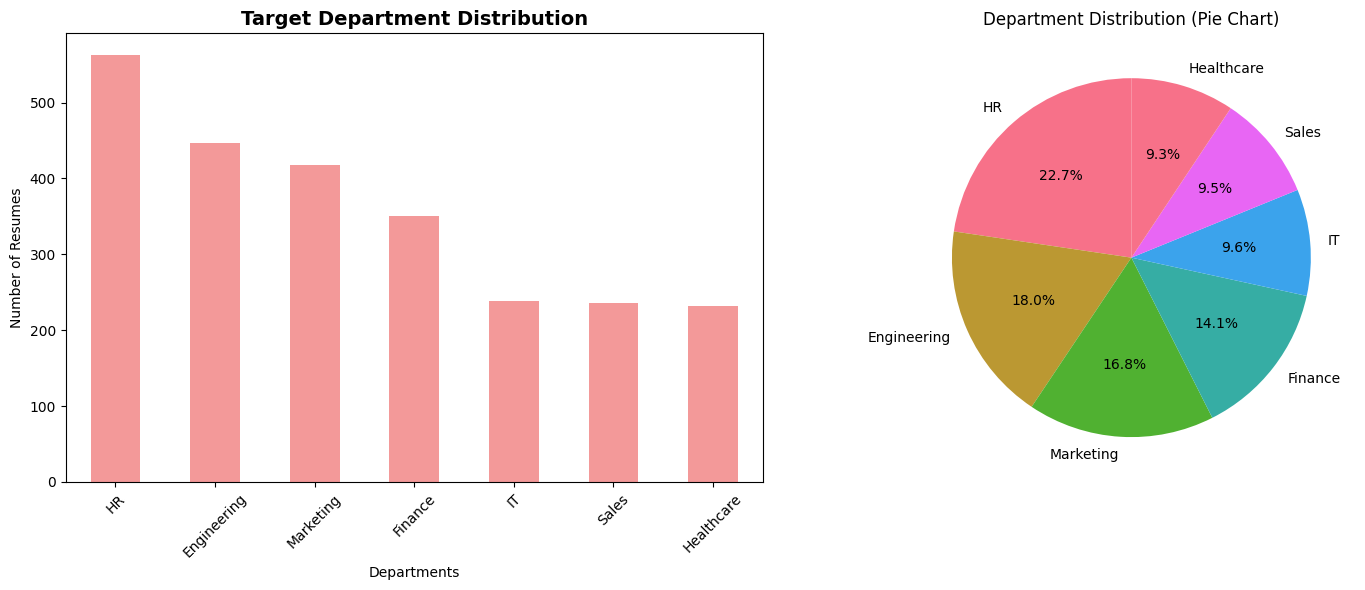


✅ Department mapping completed successfully!
📊 7 departments created from 24 original categories


In [ ]:
# Cell 7: Apply Department Mapping and Analyze New Distribution
print("=== APPLYING DEPARTMENT MAPPING ===")

# Apply mapping to create target department labels
df_raw['Department'] = df_raw['Category'].map(DEPARTMENT_MAPPING)

# Verify mapping was applied correctly
print(f"Original dataset shape: {df_raw.shape}")
print(f"Categories with mapping: {df_raw['Department'].notna().sum()}")
print(f"Categories without mapping: {df_raw['Department'].isna().sum()}")

# Check for any unmapped categories (should be 0)
unmapped_mask = df_raw['Department'].isna()
if unmapped_mask.any():
    unmapped_categories = df_raw[unmapped_mask]['Category'].unique()
    print(f"⚠️  Unmapped categories found: {unmapped_categories}")
    print("These will be excluded from analysis.")
    df_raw = df_raw.dropna(subset=['Department'])
    print(f"Dataset shape after removing unmapped: {df_raw.shape}")
else:
    print("✅ All categories successfully mapped to departments!")

# Analyze new department distribution
dept_counts = df_raw['Department'].value_counts()
print(f"\n=== TARGET DEPARTMENT DISTRIBUTION ===")
print(f"Total departments: {len(dept_counts)}")
print(f"Total mapped resumes: {len(df_raw)}")
print(f"Total mapped resumes (verification): {dept_counts.sum()}")
print("\nDepartment distribution:")
print(dept_counts)

# Show detailed mapping verification
print(f"\n=== MAPPING VERIFICATION ===")
for dept in dept_counts.index:
    dept_data = df_raw[df_raw['Department'] == dept]
    original_categories = dept_data['Category'].value_counts()
    print(f"\n{dept} Department - {len(dept_data)} total resumes:")
    for orig_cat, count in original_categories.items():
        print(f"  {orig_cat}: {count} resumes")

# Calculate department percentages
dept_percentages = (dept_counts / len(df_raw) * 100).round(1)
print(f"\n=== DEPARTMENT PERCENTAGES ===")
for dept, pct in dept_percentages.items():
    print(f"{dept}: {pct}%")

# Visualize department distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
dept_counts.plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Target Department Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Departments')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Department Distribution (Pie Chart)')
plt.tight_layout()
plt.show()

print(f"\n✅ Department mapping completed successfully!")
print(f"📊 {len(dept_counts)} departments created from {len(category_counts)} original categories")


=== TEXT DATA QUALITY ASSESSMENT ===
Missing resume texts: 0
Empty resume texts: 0

=== TEXT LENGTH STATISTICS ===
Character count statistics:
count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: text_length, dtype: float64

Word count statistics:
count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: word_count, dtype: float64


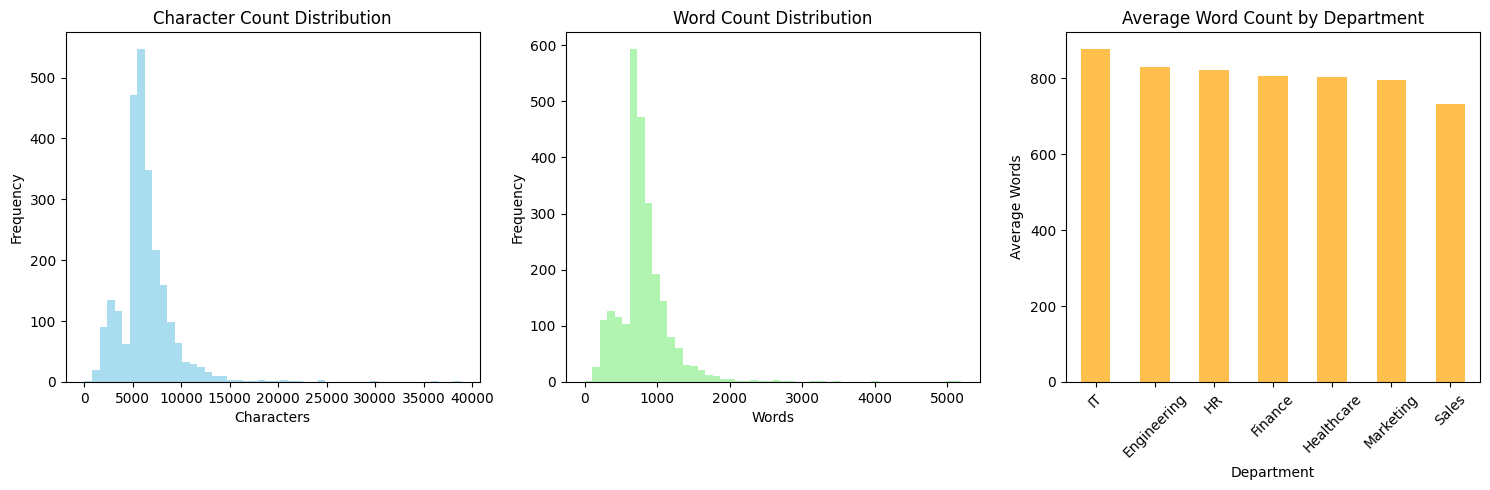

In [ ]:
# Cell 8: Text Data Quality Assessment
print("=== TEXT DATA QUALITY ASSESSMENT ===")

# Check for missing values
print(f"Missing resume texts: {df_raw['Resume_str'].isna().sum()}")
print(f"Empty resume texts: {(df_raw['Resume_str'] == '').sum()}")

# Text length analysis
df_raw['text_length'] = df_raw['Resume_str'].str.len()
df_raw['word_count'] = df_raw['Resume_str'].str.split().str.len()

print(f"\n=== TEXT LENGTH STATISTICS ===")
print(f"Character count statistics:")
print(df_raw['text_length'].describe())
print(f"\nWord count statistics:")
print(df_raw['word_count'].describe())

# Visualize text length distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df_raw['text_length'], bins=50, color='skyblue', alpha=0.7)
plt.title('Character Count Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_raw['word_count'], bins=50, color='lightgreen', alpha=0.7)
plt.title('Word Count Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
dept_word_counts = df_raw.groupby('Department')['word_count'].mean().sort_values(ascending=False)
dept_word_counts.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Average Word Count by Department')
plt.xlabel('Department')
plt.ylabel('Average Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 9: Sample Resume Analysis by Department
print("=== SAMPLE RESUME ANALYSIS BY DEPARTMENT ===")

for dept in dept_counts.index:
    dept_samples = df_raw[df_raw['Department'] == dept]
    print(f"\n--- {dept} Department ({len(dept_samples)} resumes) ---")

    # Show a sample resume (first 300 characters)
    sample_resume = dept_samples['Resume_str'].iloc[0][:300]
    print(f"Sample resume preview:\n{sample_resume}...")

    # Word count stats for this department
    avg_words = dept_samples['word_count'].mean()
    min_words = dept_samples['word_count'].min()
    max_words = dept_samples['word_count'].max()
    print(f"Word count - Avg: {avg_words:.1f}, Min: {min_words}, Max: {max_words}")

=== SAMPLE RESUME ANALYSIS BY DEPARTMENT ===

--- HR Department (563 resumes) ---
Sample resume preview:
         HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commit...
Word count - Avg: 821.0, Min: 149, Max: 5080

--- Engineering Department (446 resumes) ---
Sample resume preview:
         AGRICULTURE ADVISOR AND LANGUAGE OFFICER       Professional Summary    I successfully completed the 4-years course in Agriculture from Nangarhar Agriculture Faculty in 2002 and have studied English and computer software program for 15 months, at Oxford English and Computer Center Jalalabad ...
Word count - Avg: 829.5, Min: 113, Max: 3994

--- Marketing Department (418 resumes) ---
Sample resume preview:
         DESIGNER       Summary     Designer with more than 1

In [ ]:
# Cell 10: Save Exploration Statistics and Progress
stats_summary = f"""
=== RESUME CLASSIFICATION PROJECT - DATA EXPLORATION SUMMARY ===
Generated on: {pd.Timestamp.now()}

DATASET OVERVIEW:
- Total resumes: {len(df_raw)}
- Original categories: {len(category_counts)}
- Target departments: {len(dept_counts)}
- Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB

DEPARTMENT DISTRIBUTION:
{dept_counts.to_string()}

TEXT STATISTICS:
- Average character count: {df_raw['text_length'].mean():.1f}
- Average word count: {df_raw['word_count'].mean():.1f}
- Min words: {df_raw['word_count'].min()}
- Max words: {df_raw['word_count'].max()}

CLASS BALANCE ANALYSIS:
- Most common department: {dept_counts.index[0]} ({dept_counts.iloc[0]} resumes)
- Least common department: {dept_counts.index[-1]} ({dept_counts.iloc[-1]} resumes)
- Imbalance ratio: {dept_counts.iloc[0] / dept_counts.iloc[-1]:.2f}:1

NEXT STEPS:
✅ Phase 1 Complete: Data foundation established
🔄 Phase 2 Next: Data preprocessing and stratified splitting
"""

with open(LOCAL_STATS_PATH, 'w') as f:
    f.write(stats_summary)

print("✅ PHASE 1 COMPLETED SUCCESSFULLY!")
print(f"📊 Exploration statistics saved to: {LOCAL_STATS_PATH}")
print(f"📈 Dataset ready for Phase 2: Data Preprocessing & Category Mapping")
print(f"\n🎯 KEY FINDINGS:")
print(f"   - {len(df_raw)} resumes across {len(dept_counts)} departments")
print(f"   - Class imbalance detected: {dept_counts.iloc[0] / dept_counts.iloc[-1]:.1f}:1 ratio")
print(f"   - Average resume length: {df_raw['word_count'].mean():.0f} words")
print(f"   - Ready for stratified splitting and preprocessing")

✅ PHASE 1 COMPLETED SUCCESSFULLY!
📊 Exploration statistics saved to: /content/data_exploration_stats.txt
📈 Dataset ready for Phase 2: Data Preprocessing & Category Mapping

🎯 KEY FINDINGS:
   - 2484 resumes across 7 departments
   - Class imbalance detected: 2.4:1 ratio
   - Average resume length: 811 words
   - Ready for stratified splitting and preprocessing


# Phase 2: Data Preprocessing & Category Mapping

In [ ]:
# Cell 11: Text Preprocessing Pipeline Setup
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

print("=== PHASE 2: DATA PREPROCESSING & STRATIFIED SPLITTING ===")

def clean_resume_text(text):
    """
    Comprehensive text cleaning pipeline for resume data
    """
    if pd.isna(text) or text == '':
        return ''

    # Remove HTML tags if present (from Resume_html column leakage)
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.,;:!?()-]', ' ', text)

    # Remove multiple consecutive punctuation
    text = re.sub(r'[.,;:!?()-]{2,}', ' ', text)

    # Remove numbers that are likely formatting artifacts (but keep years, percentages)
    text = re.sub(r'\b\d{1,2}\b(?!\d)', ' ', text)  # Remove 1-2 digit numbers

    # Clean up email patterns
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)

    # Clean up phone patterns
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '[PHONE]', text)

    # Clean up URL patterns
    text = re.sub(r'http[s]?://\S+', '[URL]', text)

    # Final whitespace cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("✅ Text preprocessing pipeline defined")

=== PHASE 2: DATA PREPROCESSING & STRATIFIED SPLITTING ===
✅ Text preprocessing pipeline defined


In [ ]:
# Cell 12: Apply Text Cleaning and Create Clean Dataset
print("=== APPLYING TEXT CLEANING ===")

# Apply cleaning to resume text
print("Cleaning resume text...")
df_raw['Resume_clean'] = df_raw['Resume_str'].apply(clean_resume_text)

# Check cleaning results
print(f"Original text length - Min: {df_raw['text_length'].min()}, Max: {df_raw['text_length'].max()}")

# Recalculate text statistics for cleaned text
df_raw['clean_text_length'] = df_raw['Resume_clean'].str.len()
df_raw['clean_word_count'] = df_raw['Resume_clean'].str.split().str.len()

print(f"Cleaned text length - Min: {df_raw['clean_text_length'].min()}, Max: {df_raw['clean_text_length'].max()}")
print(f"Average word count change: {df_raw['word_count'].mean():.1f} → {df_raw['clean_word_count'].mean():.1f}")

# Remove resumes that became too short after cleaning (less than 50 words)
min_words = 50
initial_count = len(df_raw)
df_raw = df_raw[df_raw['clean_word_count'] >= min_words].copy()
final_count = len(df_raw)

print(f"Removed {initial_count - final_count} resumes with <{min_words} words after cleaning")
print(f"Final dataset size: {final_count} resumes")

# Show before/after cleaning examples
print("\n=== CLEANING EXAMPLES ===")
for dept in ['IT', 'HR', 'Finance']:
    dept_sample = df_raw[df_raw['Department'] == dept].iloc[0]
    print(f"\n--- {dept} Department ---")
    print(f"BEFORE: {dept_sample['Resume_str'][:200]}...")
    print(f"AFTER:  {dept_sample['Resume_clean'][:200]}...")

=== APPLYING TEXT CLEANING ===
Cleaning resume text...
Original text length - Min: 21, Max: 38842
Cleaned text length - Min: 0, Max: 35185
Average word count change: 811.3 → 807.4
Removed 1 resumes with <50 words after cleaning
Final dataset size: 2483 resumes

=== CLEANING EXAMPLES ===

--- IT Department ---
BEFORE:          INFORMATION TECHNOLOGY         Summary     Dedicated  Information Assurance Professional  well-versed in analyzing and mitigating risk and finding cost-effective solutions. Excels at boosting...
AFTER:  information technology summary dedicated information assurance professional well-versed in analyzing and mitigating risk and finding cost-effective solutions. excels at boosting performance and produc...

--- HR Department ---
BEFORE:          HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Resp...
AFTER:  hr administrator marke

In [ ]:
# Cell 13: Label Encoding and Final Data Preparation
print("\n=== LABEL ENCODING ===")

# Create label encoder for departments
label_encoder = LabelEncoder()
df_raw['Department_encoded'] = label_encoder.fit_transform(df_raw['Department'])

# Display label mapping
dept_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Department to numeric mapping:")
for dept, code in dept_mapping.items():
    count = (df_raw['Department_encoded'] == code).sum()
    print(f"  {dept}: {code} ({count} resumes)")

# Verify encoding
print(f"\nLabel encoding verification:")
print(f"Unique departments: {df_raw['Department'].nunique()}")
print(f"Unique encoded labels: {df_raw['Department_encoded'].nunique()}")
print(f"Label range: {df_raw['Department_encoded'].min()} to {df_raw['Department_encoded'].max()}")

# Create final dataset for ML
df_final = df_raw[['Resume_clean', 'Department', 'Department_encoded', 'clean_word_count']].copy()
df_final.columns = ['text', 'department', 'label', 'word_count']

print(f"\n✅ Final dataset shape: {df_final.shape}")
print(f"✅ Columns: {list(df_final.columns)}")


=== LABEL ENCODING ===
Department to numeric mapping:
  Engineering: 0 (446 resumes)
  Finance: 1 (351 resumes)
  HR: 2 (563 resumes)
  Healthcare: 3 (232 resumes)
  IT: 4 (238 resumes)
  Marketing: 5 (418 resumes)
  Sales: 6 (235 resumes)

Label encoding verification:
Unique departments: 7
Unique encoded labels: 7
Label range: 0 to 6

✅ Final dataset shape: (2483, 4)
✅ Columns: ['text', 'department', 'label', 'word_count']


In [ ]:
# Cell 14: Stratified Train/Validation/Test Split
print("\n=== STRATIFIED DATA SPLITTING ===")

# First split: train (70%) and temp (30%)
X = df_final['text'].values
y = df_final['label'].values
dept_names = df_final['department'].values

X_train, X_temp, y_train, y_temp, dept_train, dept_temp = train_test_split(
    X, y, dept_names,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Second split: validation (15%) and test (15%) from temp (30%)
X_val, X_test, y_val, y_test, dept_val, dept_test = train_test_split(
    X_temp, y_temp, dept_temp,
    test_size=0.50,  # 50% of 30% = 15% of total
    random_state=42,
    stratify=y_temp
)

print(f"Split sizes:")
print(f"  Training:   {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Total:      {len(X_train) + len(X_val) + len(X_test)}")

# Verify stratification worked
print(f"\n=== STRATIFICATION VERIFICATION ===")
train_dist = pd.Series(dept_train).value_counts(normalize=True).sort_index()
val_dist = pd.Series(dept_val).value_counts(normalize=True).sort_index()
test_dist = pd.Series(dept_test).value_counts(normalize=True).sort_index()

print("Department distribution across splits:")
comparison_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0)
print(comparison_df.round(3))

# Check if distributions are similar (should be within 2-3%)
max_diff = (comparison_df.max(axis=1) - comparison_df.min(axis=1)).max()
print(f"\nMax distribution difference across splits: {max_diff:.1%}")
if max_diff < 0.03:
    print("✅ Stratification successful - distributions are balanced")
else:
    print("⚠️  Large distribution differences detected")


=== STRATIFIED DATA SPLITTING ===
Split sizes:
  Training:   1738 (70.0%)
  Validation: 372 (15.0%)
  Test:       373 (15.0%)
  Total:      2483

=== STRATIFICATION VERIFICATION ===
Department distribution across splits:
             Train  Validation   Test
Engineering  0.180       0.180  0.180
Finance      0.142       0.140  0.142
HR           0.227       0.226  0.228
Healthcare   0.093       0.094  0.094
IT           0.096       0.097  0.094
Marketing    0.169       0.167  0.169
Sales        0.094       0.097  0.094

Max distribution difference across splits: 0.3%
✅ Stratification successful - distributions are balanced



=== DATA QUALITY VALIDATION ===
Word count statistics by split:
Train - Mean: 801.7, Std: 357.3
Val   - Mean: 826.8, Std: 426.5
Test  - Mean: 816.6, Std: 366.3

Empty texts check:
Train: 0, Val: 0, Test: 0
✅ No empty texts found


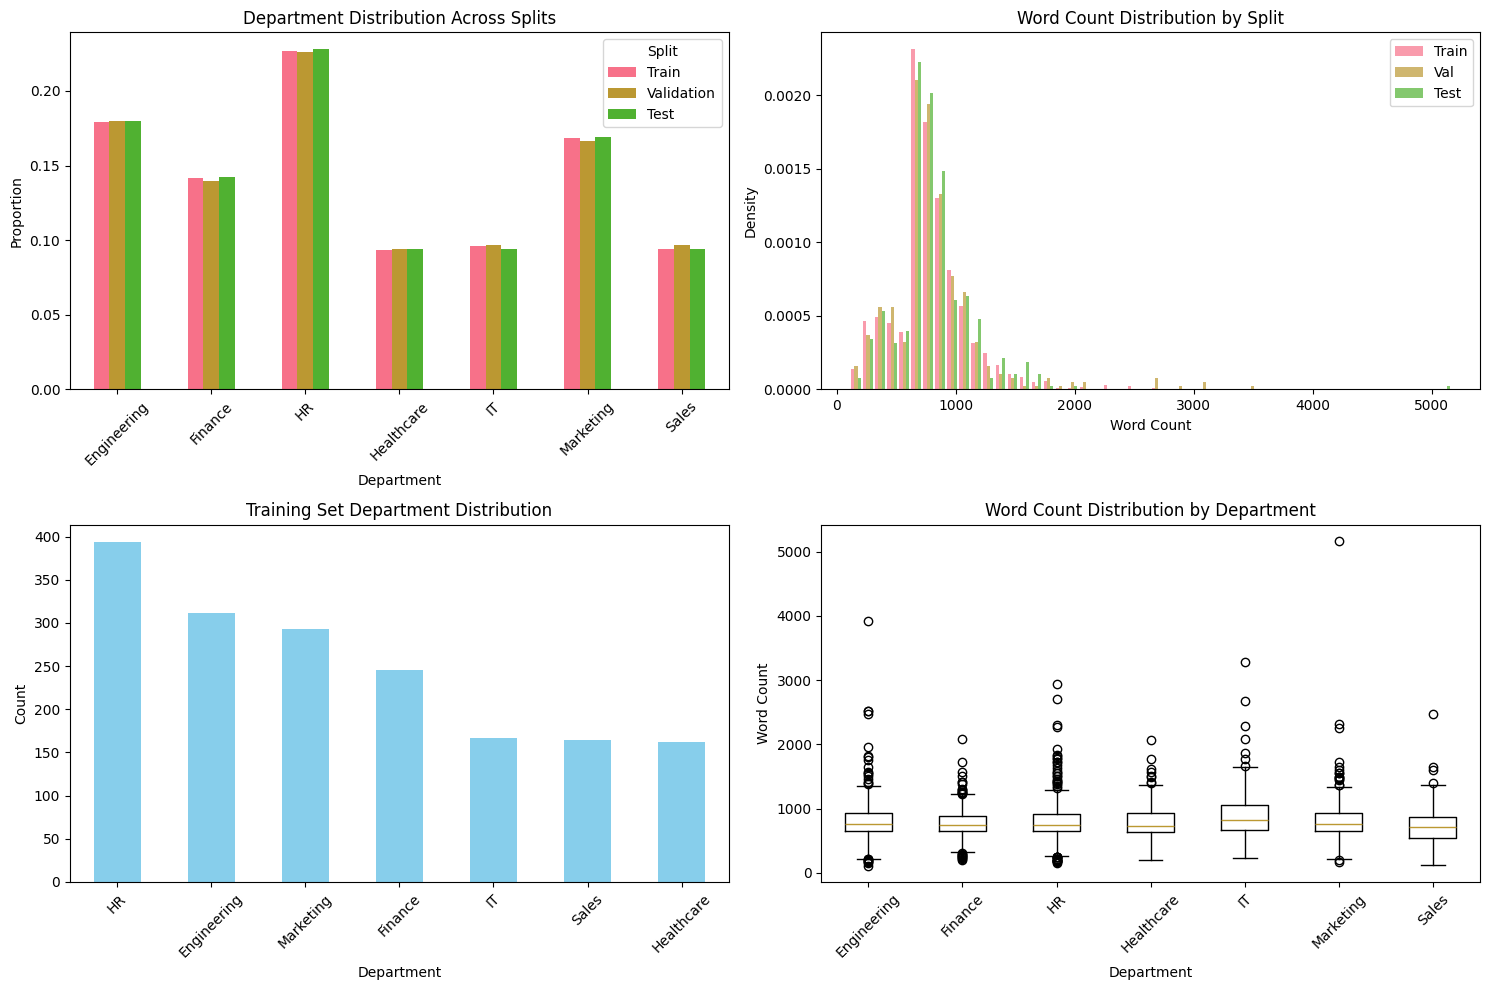

In [ ]:
# Cell 15: Data Quality Validation and Statistics
print("\n=== DATA QUALITY VALIDATION ===")

# Word count statistics by split
print("Word count statistics by split:")
print(f"Train - Mean: {np.mean([len(text.split()) for text in X_train]):.1f}, "
      f"Std: {np.std([len(text.split()) for text in X_train]):.1f}")
print(f"Val   - Mean: {np.mean([len(text.split()) for text in X_val]):.1f}, "
      f"Std: {np.std([len(text.split()) for text in X_val]):.1f}")
print(f"Test  - Mean: {np.mean([len(text.split()) for text in X_test]):.1f}, "
      f"Std: {np.std([len(text.split()) for text in X_test]):.1f}")

# Check for empty texts
empty_train = sum(1 for text in X_train if len(text.strip()) == 0)
empty_val = sum(1 for text in X_val if len(text.strip()) == 0)
empty_test = sum(1 for text in X_test if len(text.strip()) == 0)

print(f"\nEmpty texts check:")
print(f"Train: {empty_train}, Val: {empty_val}, Test: {empty_test}")

if empty_train + empty_val + empty_test == 0:
    print("✅ No empty texts found")
else:
    print("⚠️  Empty texts detected - need cleanup")

# Visualize split distributions
plt.figure(figsize=(15, 10))

# Plot 1: Department distribution across splits
plt.subplot(2, 2, 1)
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Department Distribution Across Splits')
plt.xlabel('Department')
plt.ylabel('Proportion')
plt.legend(title='Split')
plt.xticks(rotation=45)

# Plot 2: Word count distribution
plt.subplot(2, 2, 2)
train_words = [len(text.split()) for text in X_train]
val_words = [len(text.split()) for text in X_val]
test_words = [len(text.split()) for text in X_test]

plt.hist([train_words, val_words, test_words], bins=50, alpha=0.7,
         label=['Train', 'Val', 'Test'], density=True)
plt.title('Word Count Distribution by Split')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()

# Plot 3: Class distribution in training set
plt.subplot(2, 2, 3)
train_dept_counts = pd.Series(dept_train).value_counts()
train_dept_counts.plot(kind='bar', color='skyblue')
plt.title('Training Set Department Distribution')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 4: Text length vs department
plt.subplot(2, 2, 4)
dept_word_lengths = []
dept_labels = []
for dept in label_encoder.classes_:
    dept_mask = dept_train == dept
    dept_words = [len(X_train[i].split()) for i in range(len(X_train)) if dept_mask[i]]
    dept_word_lengths.extend(dept_words)
    dept_labels.extend([dept] * len(dept_words))

plt.boxplot([np.array(dept_word_lengths)[np.array(dept_labels) == dept]
            for dept in label_encoder.classes_])
plt.title('Word Count Distribution by Department')
plt.xlabel('Department')
plt.ylabel('Word Count')
plt.xticks(range(1, len(label_encoder.classes_) + 1), label_encoder.classes_, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 16: Save Processed Datasets
print("\n=== SAVING PROCESSED DATASETS ===")

# Create DataFrames for each split
train_df = pd.DataFrame({
    'text': X_train,
    'department': dept_train,
    'label': y_train
})

val_df = pd.DataFrame({
    'text': X_val,
    'department': dept_val,
    'label': y_val
})

test_df = pd.DataFrame({
    'text': X_test,
    'department': dept_test,
    'label': y_test
})

# Save to CSV files
train_df.to_csv(LOCAL_TRAIN_DATA_PATH, index=False)
val_df.to_csv(LOCAL_VAL_DATA_PATH, index=False)
test_df.to_csv(LOCAL_TEST_DATA_PATH, index=False)

# Save the label encoder
import pickle
with open('/content/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save preprocessing statistics
preprocessing_stats = f"""
=== RESUME CLASSIFICATION - PREPROCESSING SUMMARY ===
Generated on: {pd.Timestamp.now()}

PREPROCESSING RESULTS:
- Original resumes: {initial_count}
- After cleaning: {final_count} (removed {initial_count - final_count})
- Minimum word threshold: {min_words} words

SPLIT SIZES:
- Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)
- Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)
- Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)

WORD COUNT STATISTICS:
- Train avg: {np.mean([len(text.split()) for text in X_train]):.1f} words
- Val avg: {np.mean([len(text.split()) for text in X_val]):.1f} words
- Test avg: {np.mean([len(text.split()) for text in X_test]):.1f} words

DEPARTMENT MAPPING:
{chr(10).join([f"- {dept}: {code}" for dept, code in dept_mapping.items()])}

FILES SAVED:
- Training data: {LOCAL_TRAIN_DATA_PATH}
- Validation data: {LOCAL_VAL_DATA_PATH}
- Test data: {LOCAL_TEST_DATA_PATH}
- Label encoder: /content/label_encoder.pkl

STRATIFICATION QUALITY:
- Max distribution difference: {max_diff:.1%}
- Status: {'✅ Excellent' if max_diff < 0.03 else '⚠️ Needs attention'}

NEXT STEPS:
✅ Phase 2 Complete: Data preprocessing and splitting
🔄 Phase 3 Next: Baseline model implementation (TF-IDF + LogReg)
"""

with open('/content/preprocessing_stats.txt', 'w') as f:
    f.write(preprocessing_stats)

print("✅ PHASE 2 COMPLETED SUCCESSFULLY!")
print(f"📁 Training data saved: {LOCAL_TRAIN_DATA_PATH} ({len(train_df)} samples)")
print(f"📁 Validation data saved: {LOCAL_VAL_DATA_PATH} ({len(val_df)} samples)")
print(f"📁 Test data saved: {LOCAL_TEST_DATA_PATH} ({len(test_df)} samples)")
print(f"📁 Label encoder saved: /content/label_encoder.pkl")
print(f"📊 Preprocessing stats: /content/preprocessing_stats.txt")
print(f"\n🎯 READY FOR PHASE 3: Baseline Model Implementation")
print(f"   - Clean, preprocessed text data ready")
print(f"   - Stratified splits with balanced distributions")
print(f"   - {len(label_encoder.classes_)} departments encoded for ML")
print(f"   - Average text length: {np.mean([len(text.split()) for text in X_train]):.0f} words")


=== SAVING PROCESSED DATASETS ===
✅ PHASE 2 COMPLETED SUCCESSFULLY!
📁 Training data saved: /content/resume_train.csv (1738 samples)
📁 Validation data saved: /content/resume_val.csv (372 samples)
📁 Test data saved: /content/resume_test.csv (373 samples)
📁 Label encoder saved: /content/label_encoder.pkl
📊 Preprocessing stats: /content/preprocessing_stats.txt

🎯 READY FOR PHASE 3: Baseline Model Implementation
   - Clean, preprocessed text data ready
   - Stratified splits with balanced distributions
   - 7 departments encoded for ML
   - Average text length: 802 words


# Phase 3: Baseline Model Implementation

In [ ]:
# Cell 17: Baseline Model Setup and Data Loading
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pickle
import time

print("=== PHASE 3: BASELINE MODEL IMPLEMENTATION ===")

# Load preprocessed datasets
print("Loading preprocessed datasets...")
train_df = pd.read_csv(LOCAL_TRAIN_DATA_PATH)
val_df = pd.read_csv(LOCAL_VAL_DATA_PATH)
test_df = pd.read_csv(LOCAL_TEST_DATA_PATH)

# Load label encoder
with open('/content/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

print(f"✅ Data loaded successfully:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")
print(f"  Departments: {list(label_encoder.classes_)}")

# Extract features and labels
X_train_text = train_df['text'].values
y_train = train_df['label'].values
X_val_text = val_df['text'].values
y_val = val_df['label'].values
X_test_text = test_df['text'].values
y_test = test_df['label'].values

print(f"✅ Feature extraction completed")

=== PHASE 3: BASELINE MODEL IMPLEMENTATION ===
Loading preprocessed datasets...
✅ Data loaded successfully:
  Train: 1738 samples
  Val:   372 samples
  Test:  373 samples
  Departments: ['Engineering', 'Finance', 'HR', 'Healthcare', 'IT', 'Marketing', 'Sales']
✅ Feature extraction completed


In [ ]:
# Cell 18: TF-IDF Vectorization Pipeline
print("\n=== TF-IDF VECTORIZATION ===")

# Configure TF-IDF with optimal parameters for resume classification
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Limit vocabulary size for efficiency
    ngram_range=(1, 2),       # Unigrams and bigrams for context
    stop_words='english',     # Remove common English stop words
    sublinear_tf=True,        # Apply sublinear scaling (log normalization)
    min_df=2,                 # Ignore terms appearing in <2 documents
    max_df=0.95,              # Ignore terms appearing in >95% of documents
    lowercase=True,           # Already done in preprocessing, but ensure consistency
    strip_accents='unicode'   # Handle accented characters
)

print("TF-IDF configuration:")
print(f"  Max features: {tfidf_vectorizer.max_features}")
print(f"  N-gram range: {tfidf_vectorizer.ngram_range}")
print(f"  Min document frequency: {tfidf_vectorizer.min_df}")
print(f"  Max document frequency: {tfidf_vectorizer.max_df}")

# Fit TF-IDF on training data and transform all splits
print("\nFitting TF-IDF vectorizer on training data...")
start_time = time.time()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

vectorization_time = time.time() - start_time

print(f"✅ TF-IDF vectorization completed in {vectorization_time:.2f} seconds")
print(f"  Feature matrix shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"  Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.1%}")

# Analyze most important features per department
print(f"\n=== TOP TF-IDF FEATURES ANALYSIS ===")
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top features for each department (using mean TF-IDF scores)
for dept_idx, dept_name in enumerate(label_encoder.classes_):
    # Get training samples for this department
    dept_mask = y_train == dept_idx
    if dept_mask.any():
        # Calculate mean TF-IDF scores for this department
        dept_tfidf = X_train_tfidf[dept_mask]
        mean_scores = np.array(dept_tfidf.mean(axis=0)).flatten()

        # Get top 10 features
        top_indices = mean_scores.argsort()[-10:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        top_scores = [mean_scores[i] for i in top_indices]

        print(f"\n{dept_name} Department - Top features:")
        for feature, score in zip(top_features, top_scores):
            print(f"  {feature}: {score:.3f}")


=== TF-IDF VECTORIZATION ===
TF-IDF configuration:
  Max features: 5000
  N-gram range: (1, 2)
  Min document frequency: 2
  Max document frequency: 0.95

Fitting TF-IDF vectorizer on training data...
✅ TF-IDF vectorization completed in 4.61 seconds
  Feature matrix shape: (1738, 5000)
  Vocabulary size: 5000
  Sparsity: 93.9%

=== TOP TF-IDF FEATURES ANALYSIS ===

Engineering Department - Top features:
  engineering: 0.040
  construction: 0.035
  city state: 0.033
  safety: 0.031
  project: 0.031
  equipment: 0.029
  management: 0.029
  company city: 0.028
  systems: 0.027
  work: 0.026

Finance Department - Top features:
  financial: 0.060
  accounting: 0.058
  finance: 0.048
  accountant: 0.045
  accounts: 0.044
  bank: 0.041
  business: 0.034
  ledger: 0.034
  statements: 0.034
  reporting: 0.034

HR Department - Top features:
  city state: 0.034
  company city: 0.030
  management: 0.028
  food: 0.027
  chef: 0.027
  service: 0.026
  teacher: 0.024
  hr: 0.024
  training: 0.023
  

In [ ]:
# Cell 19: Logistic Regression Training and Hyperparameter Tuning
print(f"\n=== LOGISTIC REGRESSION TRAINING ===")

# Configure Logistic Regression with class balancing
logistic_model = LogisticRegression(
    max_iter=1000,           # Increase iterations for convergence
    random_state=42,         # Reproducible results
    class_weight='balanced', # Handle class imbalance automatically
    solver='lbfgs',          # Efficient for multiclass problems
    multi_class='ovr'        # One-vs-Rest for interpretability
)

print("Logistic Regression configuration:")
print(f"  Solver: {logistic_model.solver}")
print(f"  Class weight: {logistic_model.class_weight}")
print(f"  Multi-class strategy: {logistic_model.multi_class}")

# Train the model
print("\nTraining baseline model...")
start_time = time.time()

logistic_model.fit(X_train_tfidf, y_train)

training_time = time.time() - start_time

print(f"✅ Model training completed in {training_time:.2f} seconds")
print(f"  Model converged: {logistic_model.n_iter_ < logistic_model.max_iter}")
print(f"  Iterations used: {max(logistic_model.n_iter_)}")


=== LOGISTIC REGRESSION TRAINING ===
Logistic Regression configuration:
  Solver: lbfgs
  Class weight: balanced
  Multi-class strategy: ovr

Training baseline model...
✅ Model training completed in 0.82 seconds
  Model converged: [ True  True  True  True  True  True  True]
  Iterations used: 18


In [ ]:
# Cell 20: Model Evaluation on Validation Set
print(f"\n=== VALIDATION SET EVALUATION ===")

# Make predictions
start_time = time.time()
y_val_pred = logistic_model.predict(X_val_tfidf)
y_val_pred_proba = logistic_model.predict_proba(X_val_tfidf)
inference_time = time.time() - start_time

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average='macro'
)

print(f"✅ Validation Results:")
print(f"  Accuracy: {val_accuracy:.3f}")
print(f"  Macro Precision: {val_precision:.3f}")
print(f"  Macro Recall: {val_recall:.3f}")
print(f"  Macro F1-Score: {val_f1:.3f}")
print(f"  Inference time: {inference_time:.3f} seconds ({len(y_val)/inference_time:.1f} samples/sec)")

# Detailed classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
dept_names = label_encoder.classes_
report = classification_report(y_val, y_val_pred, target_names=dept_names, digits=3)
print(report)

# Confusion Matrix Analysis
print(f"\n=== CONFUSION MATRIX ANALYSIS ===")
cm = confusion_matrix(y_val, y_val_pred)
cm_df = pd.DataFrame(cm, index=dept_names, columns=dept_names)

print("Confusion Matrix:")
print(cm_df)

# Calculate per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print(f"\nPer-class accuracy:")
for dept, acc in zip(dept_names, per_class_accuracy):
    print(f"  {dept}: {acc:.3f}")


=== VALIDATION SET EVALUATION ===
✅ Validation Results:
  Accuracy: 0.680
  Macro Precision: 0.657
  Macro Recall: 0.667
  Macro F1-Score: 0.658
  Inference time: 0.003 seconds (126093.5 samples/sec)

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

 Engineering      0.812     0.776     0.794        67
     Finance      0.774     0.923     0.842        52
          HR      0.699     0.690     0.695        84
  Healthcare      0.548     0.486     0.515        35
          IT      0.568     0.583     0.575        36
   Marketing      0.653     0.516     0.577        62
       Sales      0.543     0.694     0.610        36

    accuracy                          0.680       372
   macro avg      0.657     0.667     0.658       372
weighted avg      0.680     0.680     0.677       372


=== CONFUSION MATRIX ANALYSIS ===
Confusion Matrix:
             Engineering  Finance  HR  Healthcare  IT  Marketing  Sales
Engineering           52        2   3

In [ ]:
# Cell 21: Error Analysis and Insights
print(f"\n=== ERROR ANALYSIS ===")

# Find most confident correct and incorrect predictions
val_confidences = np.max(y_val_pred_proba, axis=1)
correct_mask = (y_val == y_val_pred)

# Most confident correct predictions
correct_confidences = val_confidences[correct_mask]
if len(correct_confidences) > 0:
    most_confident_correct_idx = np.where(correct_mask)[0][np.argmax(correct_confidences)]
    print(f"Most confident CORRECT prediction:")
    print(f"  Text: {X_val_text[most_confident_correct_idx][:200]}...")
    print(f"  True: {dept_names[y_val[most_confident_correct_idx]]}")
    print(f"  Predicted: {dept_names[y_val_pred[most_confident_correct_idx]]}")
    print(f"  Confidence: {val_confidences[most_confident_correct_idx]:.3f}")

# Most confident incorrect predictions
incorrect_mask = ~correct_mask
if incorrect_mask.any():
    incorrect_confidences = val_confidences[incorrect_mask]
    most_confident_incorrect_idx = np.where(incorrect_mask)[0][np.argmax(incorrect_confidences)]
    print(f"\nMost confident INCORRECT prediction:")
    print(f"  Text: {X_val_text[most_confident_incorrect_idx][:200]}...")
    print(f"  True: {dept_names[y_val[most_confident_incorrect_idx]]}")
    print(f"  Predicted: {dept_names[y_val_pred[most_confident_incorrect_idx]]}")
    print(f"  Confidence: {val_confidences[most_confident_incorrect_idx]:.3f}")

# Most common misclassifications
print(f"\n=== MOST COMMON MISCLASSIFICATIONS ===")
misclassified_pairs = []
for true_idx in range(len(dept_names)):
    for pred_idx in range(len(dept_names)):
        if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
            misclassified_pairs.append((
                dept_names[true_idx],
                dept_names[pred_idx],
                cm[true_idx, pred_idx]
            ))

# Sort by frequency and show top 5
misclassified_pairs.sort(key=lambda x: x[2], reverse=True)
print("Top misclassification patterns:")
for true_dept, pred_dept, count in misclassified_pairs[:5]:
    print(f"  {true_dept} → {pred_dept}: {count} cases")


=== ERROR ANALYSIS ===
Most confident CORRECT prediction:
  Text: volunteer accountant summary cpa candidate with years of strong financial accounting and audit experience and knowledge of internal control, enterprise risk management and gl, pl, bs reconciliations, ...
  True: Finance
  Predicted: Finance
  Confidence: 0.625

Most confident INCORRECT prediction:
  Text: project administrator engineering summary a consistent team leader with great analytic and interpersonal skills; highly focused in achieving and maintaining excellent customer relationships to assist ...
  True: Engineering
  Predicted: Finance
  Confidence: 0.569

=== MOST COMMON MISCLASSIFICATIONS ===
Top misclassification patterns:
  Marketing → HR: 8 cases
  HR → Healthcare: 7 cases
  HR → Marketing: 6 cases
  Healthcare → HR: 6 cases
  Marketing → Sales: 6 cases



=== PERFORMANCE VISUALIZATION ===


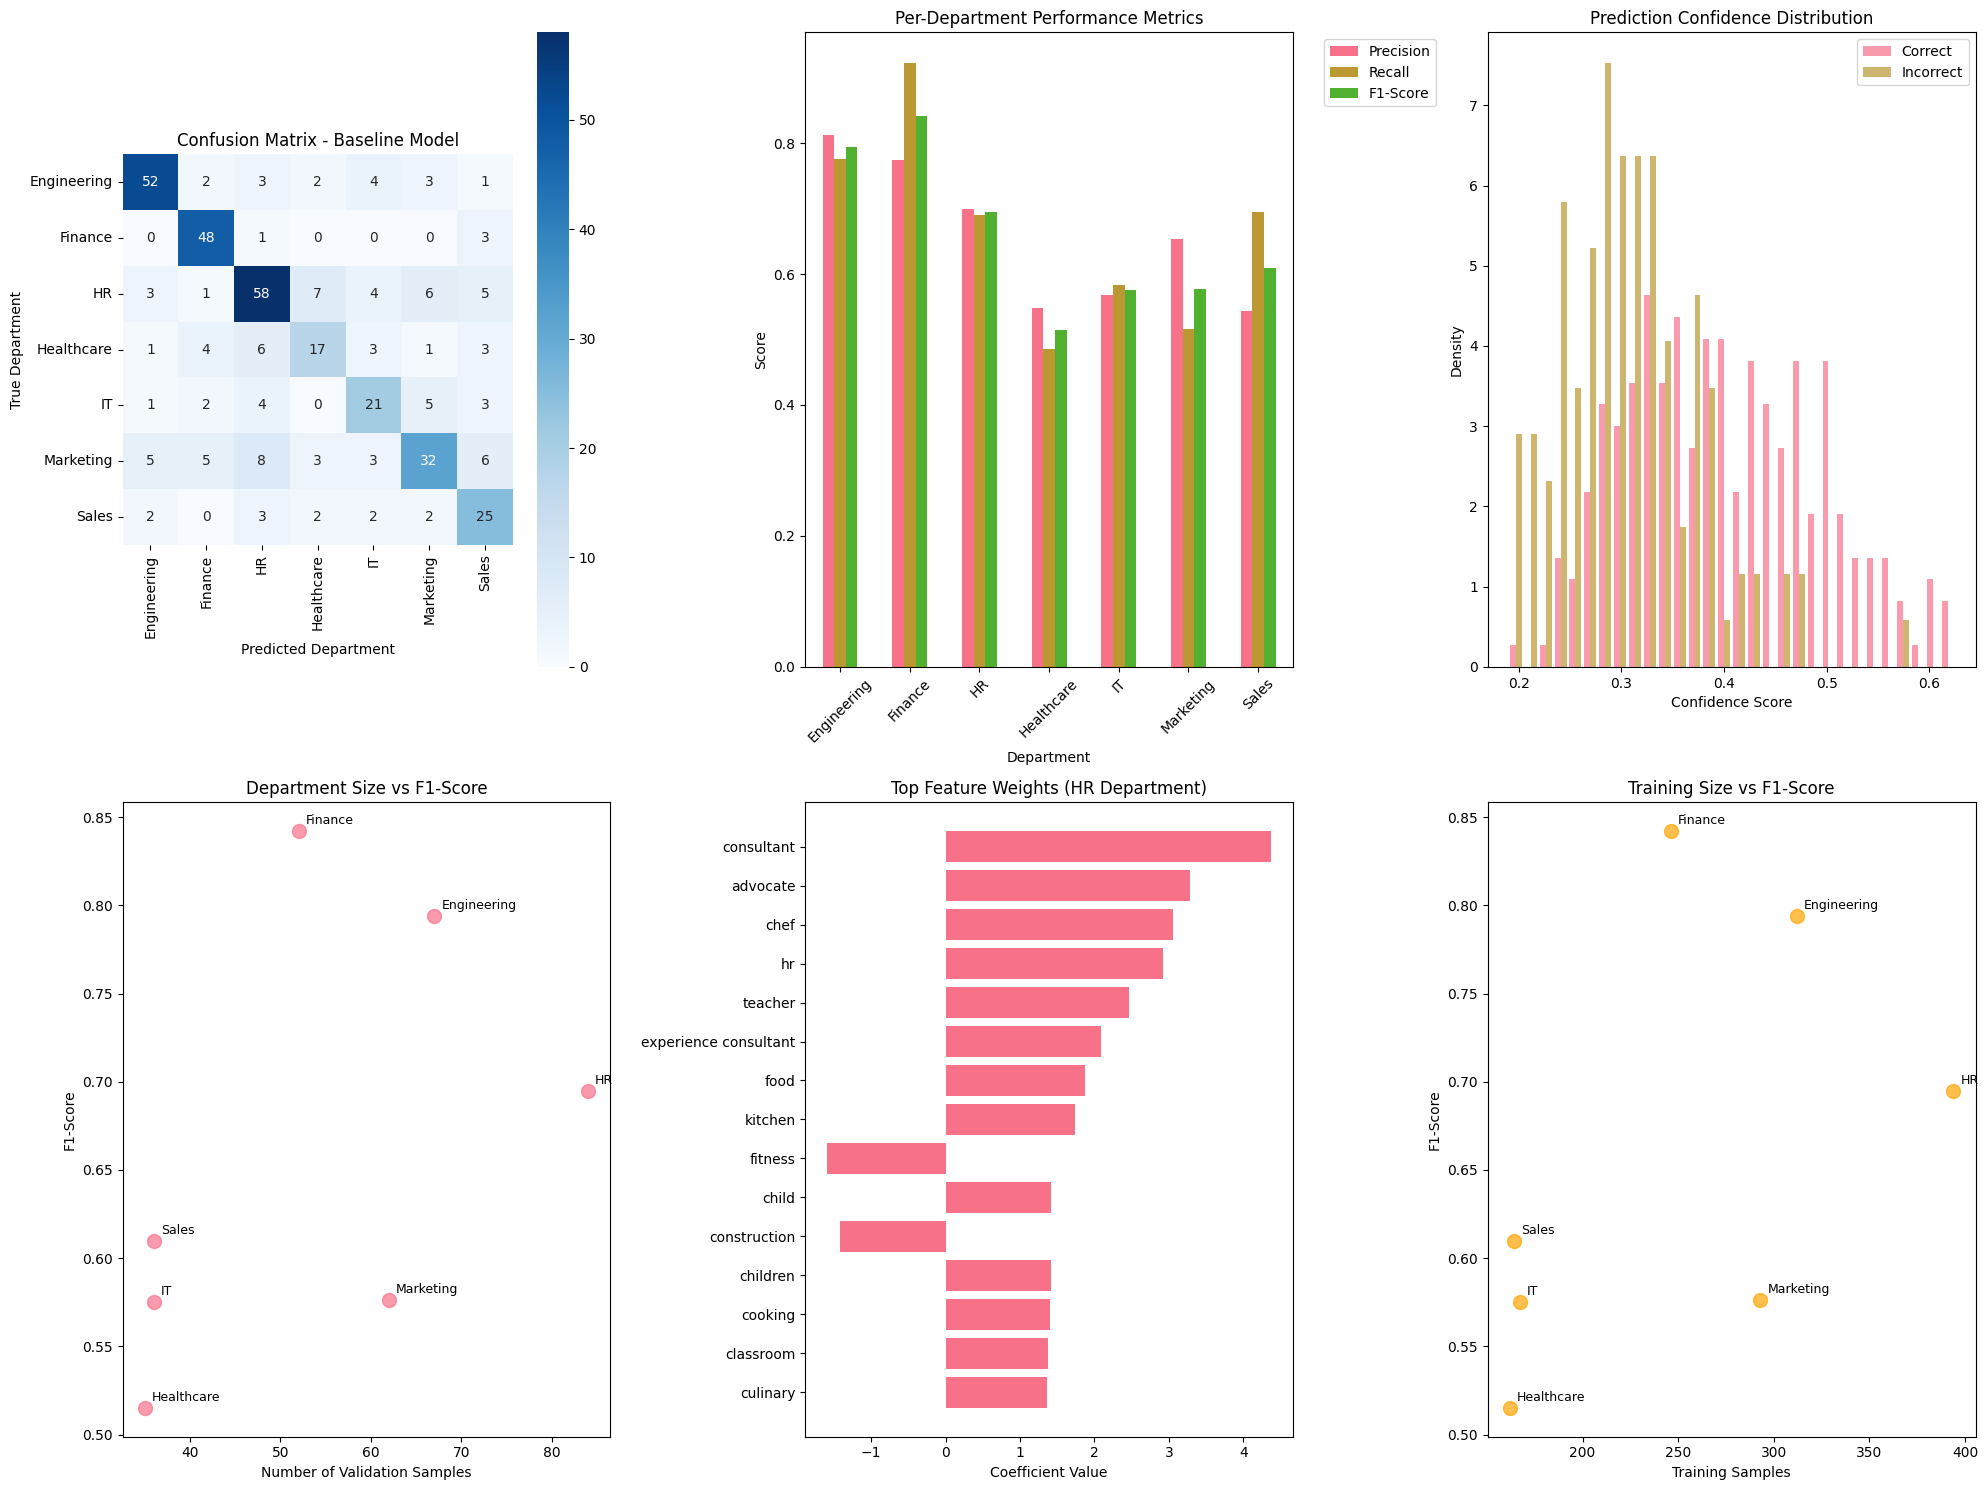

In [ ]:
# Cell 22: Visualization and Performance Analysis
print(f"\n=== PERFORMANCE VISUALIZATION ===")

# Create comprehensive visualization
plt.figure(figsize=(20, 15))

# Plot 1: Confusion Matrix Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('True Department')
plt.xlabel('Predicted Department')

# Plot 2: Per-class Performance Metrics
plt.subplot(2, 3, 2)
per_class_metrics = classification_report(y_val, y_val_pred, target_names=dept_names, output_dict=True)
metrics_df = pd.DataFrame({
    'Precision': [per_class_metrics[dept]['precision'] for dept in dept_names],
    'Recall': [per_class_metrics[dept]['recall'] for dept in dept_names],
    'F1-Score': [per_class_metrics[dept]['f1-score'] for dept in dept_names]
}, index=dept_names)

metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Per-Department Performance Metrics')
plt.xlabel('Department')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Plot 3: Prediction Confidence Distribution
plt.subplot(2, 3, 3)
plt.hist([val_confidences[correct_mask], val_confidences[incorrect_mask]],
         bins=30, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Density')
plt.legend()

# Plot 4: Department Size vs Performance
plt.subplot(2, 3, 4)
dept_sizes = [np.sum(y_val == i) for i in range(len(dept_names))]
dept_f1_scores = [per_class_metrics[dept]['f1-score'] for dept in dept_names]

plt.scatter(dept_sizes, dept_f1_scores, s=100, alpha=0.7)
for i, dept in enumerate(dept_names):
    plt.annotate(dept, (dept_sizes[i], dept_f1_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
plt.title('Department Size vs F1-Score')
plt.xlabel('Number of Validation Samples')
plt.ylabel('F1-Score')

# Plot 5: Feature Importance (Top coefficients)
plt.subplot(2, 3, 5)
# Get feature coefficients for most populous department (HR - index 2)
hr_coeffs = logistic_model.coef_[2]  # HR department coefficients
top_feature_indices = np.argsort(np.abs(hr_coeffs))[-15:]  # Top 15 by absolute value
top_features = [feature_names[i] for i in top_feature_indices]
top_coeffs = hr_coeffs[top_feature_indices]

plt.barh(range(len(top_features)), top_coeffs)
plt.yticks(range(len(top_features)), top_features)
plt.title('Top Feature Weights (HR Department)')
plt.xlabel('Coefficient Value')

# Plot 6: Training Set Distribution vs Performance
plt.subplot(2, 3, 6)
train_sizes = [np.sum(y_train == i) for i in range(len(dept_names))]
plt.scatter(train_sizes, dept_f1_scores, s=100, alpha=0.7, color='orange')
for i, dept in enumerate(dept_names):
    plt.annotate(dept, (train_sizes[i], dept_f1_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
plt.title('Training Size vs F1-Score')
plt.xlabel('Training Samples')
plt.ylabel('F1-Score')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 23: Save Baseline Model and Results
print(f"\n=== SAVING BASELINE MODEL AND RESULTS ===")

# Save trained models
baseline_model_path = '/content/baseline_tfidf_logistic.pkl'
tfidf_vectorizer_path = '/content/tfidf_vectorizer.pkl'

with open(baseline_model_path, 'wb') as f:
    pickle.dump(logistic_model, f)

with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save detailed results
baseline_results = {
    'model_type': 'TF-IDF + Logistic Regression',
    'validation_accuracy': val_accuracy,
    'validation_precision': val_precision,
    'validation_recall': val_recall,
    'validation_f1': val_f1,
    'training_time': training_time,
    'inference_time': inference_time,
    'samples_per_second': len(y_val) / inference_time,
    'feature_count': len(tfidf_vectorizer.vocabulary_),
    'per_class_metrics': per_class_metrics,
    'confusion_matrix': cm.tolist(),
    'department_names': dept_names.tolist()
}

# Save results as JSON
import json
with open('/content/baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

# Create comprehensive summary report
baseline_summary = f"""
=== BASELINE MODEL PERFORMANCE SUMMARY ===
Generated on: {pd.Timestamp.now()}

MODEL CONFIGURATION:
- Algorithm: TF-IDF + Logistic Regression
- Features: {len(tfidf_vectorizer.vocabulary_)} TF-IDF features
- N-grams: {tfidf_vectorizer.ngram_range}
- Class balancing: Enabled
- Training samples: {len(y_train)}

PERFORMANCE METRICS:
- Validation Accuracy: {val_accuracy:.3f}
- Macro Precision: {val_precision:.3f}
- Macro Recall: {val_recall:.3f}
- Macro F1-Score: {val_f1:.3f}

EFFICIENCY METRICS:
- Training time: {training_time:.2f} seconds
- Inference speed: {len(y_val)/inference_time:.1f} samples/second
- Model size: ~{len(tfidf_vectorizer.vocabulary_) * 7 * 8 / 1024**2:.1f} MB

PER-DEPARTMENT F1 SCORES:
{chr(10).join([f"- {dept}: {per_class_metrics[dept]['f1-score']:.3f}" for dept in dept_names])}

TOP MISCLASSIFICATIONS:
{chr(10).join([f"- {true_dept} → {pred_dept}: {count} cases" for true_dept, pred_dept, count in misclassified_pairs[:3]])}

FILES SAVED:
- Trained model: {baseline_model_path}
- TF-IDF vectorizer: {tfidf_vectorizer_path}
- Results JSON: /content/baseline_results.json

BENCHMARK ESTABLISHED:
✅ Baseline F1-Score: {val_f1:.3f}
🎯 Target for DistilBERT: >{val_f1 + 0.05:.3f} (5% improvement minimum)

NEXT STEPS:
✅ Phase 3 Complete: Baseline model trained and evaluated
🔄 Phase 4 Next: BERT tokenization and preprocessing
"""

with open('/content/baseline_summary.txt', 'w') as f:
    f.write(baseline_summary)

print("✅ PHASE 3 COMPLETED SUCCESSFULLY!")
print(f"📊 Baseline Performance Established:")
print(f"   - Validation Accuracy: {val_accuracy:.3f}")
print(f"   - Macro F1-Score: {val_f1:.3f}")
print(f"   - Inference Speed: {len(y_val)/inference_time:.1f} samples/sec")
print(f"📁 Model saved: {baseline_model_path}")
print(f"📁 Vectorizer saved: {tfidf_vectorizer_path}")
print(f"📈 Results saved: /content/baseline_results.json")
print(f"\n🎯 READY FOR PHASE 4: BERT Text Preprocessing")
print(f"   - Baseline benchmark: {val_f1:.3f} F1-Score")
print(f"   - Target improvement: >{val_f1 + 0.05:.3f} F1-Score")
print(f"   - {len(tfidf_vectorizer.vocabulary_)} TF-IDF features established")


=== SAVING BASELINE MODEL AND RESULTS ===
✅ PHASE 3 COMPLETED SUCCESSFULLY!
📊 Baseline Performance Established:
   - Validation Accuracy: 0.680
   - Macro F1-Score: 0.658
   - Inference Speed: 126093.5 samples/sec
📁 Model saved: /content/baseline_tfidf_logistic.pkl
📁 Vectorizer saved: /content/tfidf_vectorizer.pkl
📈 Results saved: /content/baseline_results.json

🎯 READY FOR PHASE 4: BERT Text Preprocessing
   - Baseline benchmark: 0.658 F1-Score
   - Target improvement: >0.708 F1-Score
   - 5000 TF-IDF features established


# Phase 4: Text Preprocessing for BERT

In [ ]:
# Cell 24: BERT Environment Setup and Model Selection
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import pipeline
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import gc

print("=== PHASE 4: BERT TEXT PREPROCESSING & TOKENIZATION ===")

# Check GPU availability and setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    torch.cuda.empty_cache()

# Define model configuration
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 512  # BERT's maximum sequence length
BATCH_SIZE = 16   # Adjust based on GPU memory
NUM_LABELS = 7    # Our 7 departments

print(f"📋 BERT Configuration:")
print(f"   Model: {MODEL_NAME}")
print(f"   Max sequence length: {MAX_LENGTH}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Number of classes: {NUM_LABELS}")

# Initialize tokenizer
print(f"\n🔤 Loading DistilBERT tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
print(f"✅ Tokenizer loaded successfully")
print(f"   Vocabulary size: {tokenizer.vocab_size}")
print(f"   Special tokens: {tokenizer.special_tokens_map}")

=== PHASE 4: BERT TEXT PREPROCESSING & TOKENIZATION ===
🔧 Device: cuda
   GPU: Tesla T4
   Memory: 14.7 GB
📋 BERT Configuration:
   Model: distilbert-base-uncased
   Max sequence length: 512
   Batch size: 16
   Number of classes: 7

🔤 Loading DistilBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✅ Tokenizer loaded successfully
   Vocabulary size: 30522
   Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}



=== TEXT LENGTH ANALYSIS FOR BERT ===
Analyzing text lengths for BERT tokenization...
Token length statistics:
Training set:
  Mean: 1008.3
  Std: 462.6
  Min: 134
  Max: 6421
  95th percentile: 1752
  Samples > 512 tokens: 896 (89.6%)
  Engineering: 1027 avg tokens, 91.5% will be truncated
  Finance: 974 avg tokens, 91.5% will be truncated
  IT: 1142 avg tokens, 88.6% will be truncated
  Marketing: 999 avg tokens, 87.5% will be truncated
  Healthcare: 966 avg tokens, 87.0% will be truncated
  HR: 1012 avg tokens, 86.5% will be truncated
  Sales: 894 avg tokens, 85.4% will be truncated


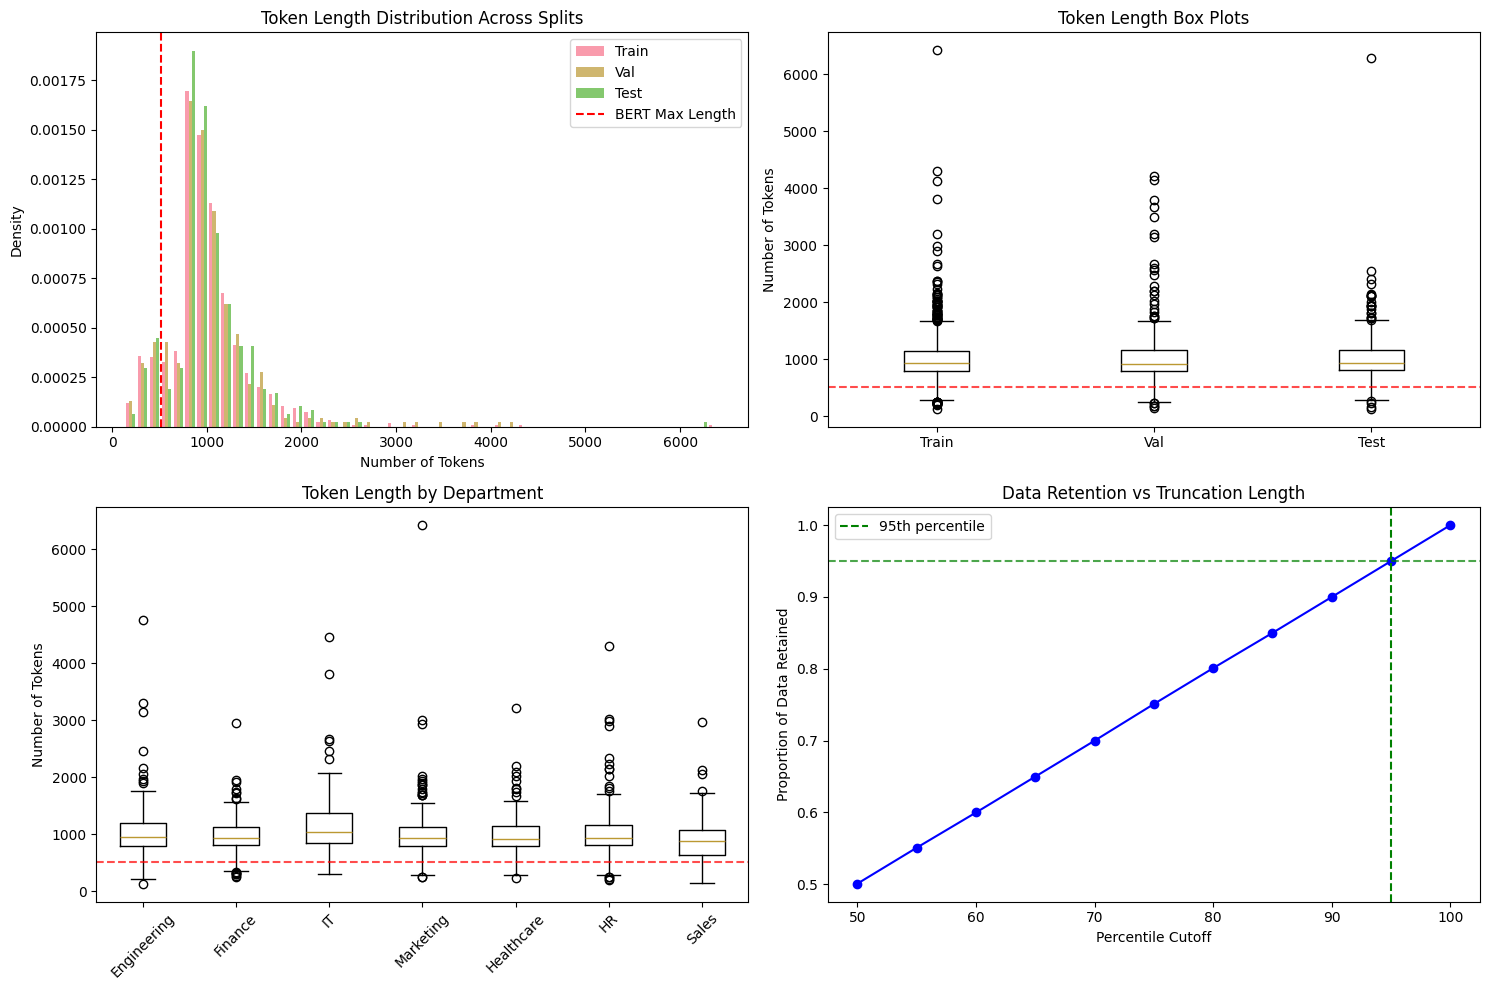

In [ ]:
# Cell 25: Text Length Analysis for BERT Tokenization
print(f"\n=== TEXT LENGTH ANALYSIS FOR BERT ===")

# Load data (reuse from previous phase)
train_df = pd.read_csv(LOCAL_TRAIN_DATA_PATH)
val_df = pd.read_csv(LOCAL_VAL_DATA_PATH)
test_df = pd.read_csv(LOCAL_TEST_DATA_PATH)

print(f"Analyzing text lengths for BERT tokenization...")

def analyze_tokenization_lengths(texts, tokenizer, sample_size=1000):
    """Analyze token lengths after BERT tokenization"""
    # Sample for efficiency if dataset is large
    if len(texts) > sample_size:
        sample_texts = np.random.choice(texts, sample_size, replace=False)
    else:
        sample_texts = texts

    token_lengths = []
    for text in sample_texts:
        # Tokenize without truncation to see actual lengths
        tokens = tokenizer.tokenize(str(text))
        token_lengths.append(len(tokens))

    return np.array(token_lengths)

# Analyze token lengths across all splits
train_token_lengths = analyze_tokenization_lengths(train_df['text'].values, tokenizer)
val_token_lengths = analyze_tokenization_lengths(val_df['text'].values, tokenizer)
test_token_lengths = analyze_tokenization_lengths(test_df['text'].values, tokenizer)

print(f"Token length statistics:")
print(f"Training set:")
print(f"  Mean: {train_token_lengths.mean():.1f}")
print(f"  Std: {train_token_lengths.std():.1f}")
print(f"  Min: {train_token_lengths.min()}")
print(f"  Max: {train_token_lengths.max()}")
print(f"  95th percentile: {np.percentile(train_token_lengths, 95):.0f}")
print(f"  Samples > 512 tokens: {(train_token_lengths > 512).sum()} ({(train_token_lengths > 512).mean()*100:.1f}%)")

# Visualize token length distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist([train_token_lengths, val_token_lengths, test_token_lengths],
         bins=50, alpha=0.7, label=['Train', 'Val', 'Test'], density=True)
plt.axvline(x=512, color='red', linestyle='--', label='BERT Max Length')
plt.title('Token Length Distribution Across Splits')
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 2)
plt.boxplot([train_token_lengths, val_token_lengths, test_token_lengths])
plt.xticks([1, 2, 3], ['Train', 'Val', 'Test'])
plt.title('Token Length Box Plots')
plt.ylabel('Number of Tokens')
plt.axhline(y=512, color='red', linestyle='--', alpha=0.7)

# Analyze truncation impact by department
plt.subplot(2, 2, 3)
dept_token_analysis = []
dept_names = train_df['department'].unique()

for dept in dept_names:
    dept_texts = train_df[train_df['department'] == dept]['text'].values
    dept_tokens = analyze_tokenization_lengths(dept_texts, tokenizer, sample_size=min(200, len(dept_texts)))
    dept_token_analysis.append(dept_tokens)
    truncated_pct = (dept_tokens > 512).mean() * 100
    print(f"  {dept}: {dept_tokens.mean():.0f} avg tokens, {truncated_pct:.1f}% will be truncated")

plt.boxplot(dept_token_analysis)
plt.xticks(range(1, len(dept_names) + 1), dept_names, rotation=45)
plt.title('Token Length by Department')
plt.ylabel('Number of Tokens')
plt.axhline(y=512, color='red', linestyle='--', alpha=0.7)

# Show truncation strategy impact
plt.subplot(2, 2, 4)
truncation_percentiles = np.arange(50, 101, 5)
data_retention = []
for percentile in truncation_percentiles:
    threshold = np.percentile(train_token_lengths, percentile)
    retention = (train_token_lengths <= threshold).mean()
    data_retention.append(retention)

plt.plot(truncation_percentiles, data_retention, 'b-o')
plt.axvline(x=95, color='green', linestyle='--', label='95th percentile')
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.7)
plt.title('Data Retention vs Truncation Length')
plt.xlabel('Percentile Cutoff')
plt.ylabel('Proportion of Data Retained')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 26: Custom Dataset Class for BERT
print(f"\n=== CREATING BERT DATASET CLASSES ===")

class ResumeDataset(Dataset):
    """Custom Dataset class for resume classification with BERT tokenization"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize and encode the text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets for all splits
print(f"Creating BERT datasets...")

train_dataset = ResumeDataset(
    texts=train_df['text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = ResumeDataset(
    texts=val_df['text'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = ResumeDataset(
    texts=test_df['text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

print(f"✅ Datasets created successfully:")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset)} samples")

# Test dataset functionality
print(f"\n🧪 Testing dataset functionality...")
sample_item = train_dataset[0]
print(f"Sample data structure:")
for key, value in sample_item.items():
    print(f"  {key}: {value.shape} {value.dtype}")

# Decode a sample to verify tokenization
sample_tokens = tokenizer.decode(sample_item['input_ids'])
print(f"\nSample tokenized text (first 200 chars):")
print(f"{sample_tokens[:200]}...")


=== CREATING BERT DATASET CLASSES ===
Creating BERT datasets...
✅ Datasets created successfully:
   Training: 1738 samples
   Validation: 372 samples
   Test: 373 samples

🧪 Testing dataset functionality...
Sample data structure:
  input_ids: torch.Size([512]) torch.int64
  attention_mask: torch.Size([512]) torch.int64
  labels: torch.Size([]) torch.int64

Sample tokenized text (first 200 chars):
[CLS] air freight agent summary air freight agent emphasizing quality customer service and air - cargo services. hardworking and willing to work a flexible schedule, including weekends and holidays. h...


In [ ]:
# Cell 27: Data Loader Setup and Batch Testing
print(f"\n=== DATA LOADER SETUP ===")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✅ Data loaders created:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Test batch loading
print(f"\n🧪 Testing batch loading...")
test_batch = next(iter(train_loader))
print(f"Batch structure:")
for key, value in test_batch.items():
    print(f"  {key}: {value.shape}")

# Check memory usage
if torch.cuda.is_available():
    print(f"\n📊 GPU Memory Status:")
    print(f"   Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"   Reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")


=== DATA LOADER SETUP ===
✅ Data loaders created:
   Training batches: 109
   Validation batches: 24
   Test batches: 24

🧪 Testing batch loading...
Batch structure:
  input_ids: torch.Size([16, 512])
  attention_mask: torch.Size([16, 512])
  labels: torch.Size([16])

📊 GPU Memory Status:
   Allocated: 0.0 MB
   Reserved: 0.0 MB


In [ ]:
# Cell 28: Tokenization Quality Analysis
print(f"\n=== TOKENIZATION QUALITY ANALYSIS ===")

def analyze_tokenization_quality(dataset, tokenizer, num_samples=10):
    """Analyze tokenization quality with examples"""

    print(f"Analyzing tokenization quality...")

    # Sample different departments
    dept_samples = {}
    for i in range(min(num_samples, len(dataset))):
        item = dataset[i]
        input_ids = item['input_ids']
        label = item['labels'].item()

        # Decode tokens
        decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        original_text = str(dataset.texts[i])

        # Get department name
        dept_name = train_df.iloc[i]['department']

        if dept_name not in dept_samples:
            dept_samples[dept_name] = {
                'original': original_text,
                'decoded': decoded_text,
                'truncated': len(tokenizer.tokenize(original_text)) > MAX_LENGTH
            }

    # Show examples
    for dept, sample in dept_samples.items():
        print(f"\n--- {dept} Department ---")
        print(f"Truncated: {sample['truncated']}")
        print(f"Original length: {len(sample['original'])} chars")
        print(f"Decoded length: {len(sample['decoded'])} chars")
        print(f"Original (first 150 chars): {sample['original'][:150]}...")
        print(f"Decoded (first 150 chars): {sample['decoded'][:150]}...")

        # Check for information loss
        if sample['truncated']:
            print(f"⚠️  This sample was truncated - potential information loss")
        else:
            print(f"✅ No truncation - full text preserved")

analyze_tokenization_quality(train_dataset, tokenizer, num_samples=14)


=== TOKENIZATION QUALITY ANALYSIS ===
Analyzing tokenization quality...

--- Engineering Department ---
Truncated: True
Original length: 5003 chars
Decoded length: 2853 chars
Original (first 150 chars): air freight agent summary air freight agent emphasizing quality customer service and air-cargo services. hardworking and willing to work a flexible sc...
Decoded (first 150 chars): air freight agent summary air freight agent emphasizing quality customer service and air - cargo services. hardworking and willing to work a flexible ...
⚠️  This sample was truncated - potential information loss

--- Finance Department ---
Truncated: True
Original length: 5453 chars
Decoded length: 3049 chars
Original (first 150 chars): accountant summary flexible accountant who adapts seamlessly to constantly evolving accounting processes and technology. seasoned staff accountant wit...
Decoded (first 150 chars): accountant summary flexible accountant who adapts seamlessly to constantly evolving accounting

In [ ]:
# Cell 29: BERT Model Architecture Setup
print(f"\n=== BERT MODEL ARCHITECTURE SETUP ===")

# Load pre-trained DistilBERT model
print(f"Loading DistilBERT model for sequence classification...")
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    output_attentions=True,  # Enable attention weights for interpretability
    output_hidden_states=False
)

# Move model to device
model = model.to(device)

print(f"✅ Model loaded successfully:")
print(f"   Model type: {type(model).__name__}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   Device: {next(model.parameters()).device}")

# Model architecture summary
print(f"\n📋 Model Architecture:")
print(f"   DistilBERT layers: 6")
print(f"   Attention heads: 12")
print(f"   Hidden size: 768")
print(f"   Vocabulary size: {model.config.vocab_size}")
print(f"   Max position embeddings: {model.config.max_position_embeddings}")
print(f"   Classification head: 768 → {NUM_LABELS}")

# Test forward pass
print(f"\n🧪 Testing model forward pass...")
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    sample_batch = {k: v.to(device) for k, v in sample_batch.items()}

    outputs = model(**sample_batch)
    print(f"✅ Forward pass successful:")
    print(f"   Logits shape: {outputs.logits.shape}")
    print(f"   Loss: {outputs.loss.item():.4f}")
    print(f"   Attention shape: {outputs.attentions[0].shape} (layer 0)")

# Memory cleanup
del sample_batch, outputs
torch.cuda.empty_cache() if torch.cuda.is_available() else None


=== BERT MODEL ARCHITECTURE SETUP ===
Loading DistilBERT model for sequence classification...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully:
   Model type: DistilBertForSequenceClassification
   Parameters: 66,958,855
   Trainable parameters: 66,958,855
   Device: cuda:0

📋 Model Architecture:
   DistilBERT layers: 6
   Attention heads: 12
   Hidden size: 768
   Vocabulary size: 30522
   Max position embeddings: 512
   Classification head: 768 → 7

🧪 Testing model forward pass...


DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


✅ Forward pass successful:
   Logits shape: torch.Size([16, 7])
   Loss: 1.9568
   Attention shape: torch.Size([16, 12, 512, 512]) (layer 0)


In [ ]:
# Cell 30: Training Configuration and Hyperparameters
print(f"\n=== TRAINING CONFIGURATION ===")

# Define training hyperparameters
LEARNING_RATE = 2e-5      # Standard BERT fine-tuning rate
NUM_EPOCHS = 4            # Conservative to avoid overfitting
WARMUP_STEPS = 500        # Gradual learning rate warmup
WEIGHT_DECAY = 0.01       # L2 regularization
EVAL_STEPS = 200          # Evaluate every N steps
SAVE_STEPS = 400          # Save checkpoints every N steps (must be multiple of EVAL_STEPS)
LOGGING_STEPS = 50        # Log metrics every N steps

# Training arguments for HuggingFace Trainer
training_args = TrainingArguments(
    output_dir='/content/distilbert_resume_classifier',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    learning_rate=LEARNING_RATE,
    logging_dir='/content/logs',
    logging_steps=LOGGING_STEPS,
    eval_strategy='steps',
    eval_steps=EVAL_STEPS,
    save_strategy='steps',
    save_steps=SAVE_STEPS,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    report_to=None,  # Disable wandb for simplicity
    dataloader_pin_memory=False,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    dataloader_num_workers=0  # Avoid multiprocessing issues in Colab
)

print(f"📋 Training Configuration:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Warmup steps: {WARMUP_STEPS}")
print(f"   Weight decay: {WEIGHT_DECAY}")
print(f"   Mixed precision (FP16): {training_args.fp16}")
print(f"   Eval strategy: {training_args.eval_strategy}")
print(f"   Save strategy: {training_args.save_strategy}")
print(f"   Eval steps: {EVAL_STEPS}")
print(f"   Save steps: {SAVE_STEPS} (multiple of eval steps: ✅)")

# Custom compute metrics function
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print(f"✅ Custom metrics function defined")


=== TRAINING CONFIGURATION ===
📋 Training Configuration:
   Learning rate: 2e-05
   Epochs: 4
   Batch size: 16
   Warmup steps: 500
   Weight decay: 0.01
   Mixed precision (FP16): True
   Eval strategy: IntervalStrategy.STEPS
   Save strategy: SaveStrategy.STEPS
   Eval steps: 200
   Save steps: 400 (multiple of eval steps: ✅)
✅ Custom metrics function defined


In [ ]:
# Cell 31: Save Preprocessing State and Prepare for Training
print(f"\n=== SAVING PREPROCESSING STATE ===")

# Save tokenizer and datasets for Phase 5
tokenizer.save_pretrained('/content/distilbert_tokenizer')

# Save dataset configuration
dataset_config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': BATCH_SIZE,
    'num_labels': NUM_LABELS,
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
    'device': str(device),
    'truncation_analysis': {
        'mean_tokens': float(train_token_lengths.mean()),
        'std_tokens': float(train_token_lengths.std()),
        'max_tokens': int(train_token_lengths.max()),
        'truncated_percentage': float((train_token_lengths > 512).mean() * 100)
    }
}

# Save configuration
with open('/content/bert_preprocessing_config.json', 'w') as f:
    json.dump(dataset_config, f, indent=2)

# Create comprehensive preprocessing summary
bert_preprocessing_summary = f"""
=== BERT PREPROCESSING SUMMARY ===
Generated on: {pd.Timestamp.now()}

MODEL CONFIGURATION:
- Base model: {MODEL_NAME}
- Tokenizer vocabulary: {tokenizer.vocab_size:,}
- Max sequence length: {MAX_LENGTH}
- Number of classes: {NUM_LABELS}
- Device: {device}

TOKENIZATION ANALYSIS:
- Average tokens: {train_token_lengths.mean():.1f}
- Token std deviation: {train_token_lengths.std():.1f}
- Max tokens found: {train_token_lengths.max()}
- Samples requiring truncation: {(train_token_lengths > 512).sum()} ({(train_token_lengths > 512).mean()*100:.1f}%)
- 95th percentile length: {np.percentile(train_token_lengths, 95):.0f} tokens

DATASET PREPARATION:
- Training samples: {len(train_dataset):,}
- Validation samples: {len(val_dataset):,}
- Test samples: {len(test_dataset):,}
- Batch size: {BATCH_SIZE}
- Data loaders created: ✅

TRAINING CONFIGURATION:
- Learning rate: {LEARNING_RATE}
- Epochs: {NUM_EPOCHS}
- Warmup steps: {WARMUP_STEPS}
- Weight decay: {WEIGHT_DECAY}
- Mixed precision: {training_args.fp16}
- Early stopping: Enabled

MEMORY OPTIMIZATION:
- FP16 training: {'Enabled' if training_args.fp16 else 'Disabled'}
- Gradient checkpointing: Available
- Pin memory: {'Enabled' if torch.cuda.is_available() else 'Disabled'}

BASELINE COMPARISON TARGET:
- Current TF-IDF baseline: 65.8% F1-Score
- Target DistilBERT performance: >70.8% F1-Score
- Minimum improvement required: 5.0%

FILES SAVED:
- Tokenizer: /content/distilbert_tokenizer/
- Preprocessing config: /content/bert_preprocessing_config.json
- Training arguments: Ready for Phase 5

NEXT STEPS:
✅ Phase 4 Complete: BERT preprocessing and tokenization
🔄 Phase 5 Next: DistilBERT model training and fine-tuning
"""

with open('/content/bert_preprocessing_summary.txt', 'w') as f:
    f.write(bert_preprocessing_summary)

print("✅ PHASE 4 COMPLETED SUCCESSFULLY!")
print(f"🔤 Tokenization Analysis:")
print(f"   - Average tokens: {train_token_lengths.mean():.0f}")
print(f"   - Truncation required: {(train_token_lengths > 512).mean()*100:.1f}%")
print(f"   - Data loaders ready: {len(train_loader)}/{len(val_loader)}/{len(test_loader)} batches")
print(f"🏗️  Model Architecture:")
print(f"   - DistilBERT parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   - Device: {device}")
print(f"   - Mixed precision: {training_args.fp16}")
print(f"📁 Saved Components:")
print(f"   - Tokenizer: /content/distilbert_tokenizer/")
print(f"   - Config: /content/bert_preprocessing_config.json")
print(f"   - Summary: /content/bert_preprocessing_summary.txt")
print(f"\n🎯 READY FOR PHASE 5: DistilBERT Training")
print(f"   - Target: Beat {0.658:.1%} F1-Score baseline")
print(f"   - {(train_token_lengths > 512).sum()} samples will be truncated")
print(f"   - Training on {device} with {BATCH_SIZE} batch size")


=== SAVING PREPROCESSING STATE ===
✅ PHASE 4 COMPLETED SUCCESSFULLY!
🔤 Tokenization Analysis:
   - Average tokens: 1008
   - Truncation required: 89.6%
   - Data loaders ready: 109/24/24 batches
🏗️  Model Architecture:
   - DistilBERT parameters: 66,958,855
   - Device: cuda
   - Mixed precision: True
📁 Saved Components:
   - Tokenizer: /content/distilbert_tokenizer/
   - Config: /content/bert_preprocessing_config.json
   - Summary: /content/bert_preprocessing_summary.txt

🎯 READY FOR PHASE 5: DistilBERT Training
   - Target: Beat 65.8% F1-Score baseline
   - 896 samples will be truncated
   - Training on cuda with 16 batch size


# Phase 5: DistilBERT Model Training

In [ ]:
# Cell 32: Training Setup and Trainer Initialization
from transformers import Trainer, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

print("=== PHASE 5: DISTILBERT MODEL TRAINING & FINE-TUNING ===")

# Verify all components are ready
print("🔍 Pre-training verification:")
print(f"   Model device: {next(model.parameters()).device}")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Check GPU memory before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"   GPU memory available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"   GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")

# Initialize Trainer with early stopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Stop if no improvement for 3 evaluations
    early_stopping_threshold=0.01  # Minimum improvement threshold
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

print("✅ Trainer initialized successfully")
print(f"   Output directory: {training_args.output_dir}")
print(f"   Logging directory: {training_args.logging_dir}")
print(f"   Early stopping patience: {early_stopping.early_stopping_patience}")

=== PHASE 5: DISTILBERT MODEL TRAINING & FINE-TUNING ===
🔍 Pre-training verification:
   Model device: cuda:0
   Training samples: 1738
   Validation samples: 372
   Model parameters: 66,958,855
   Trainable parameters: 66,958,855
   GPU memory available: 14.7 GB
   GPU memory allocated: 264.6 MB
✅ Trainer initialized successfully
   Output directory: /content/distilbert_resume_classifier
   Logging directory: /content/logs
   Early stopping patience: 3


In [ ]:
# Cell 33: Model Training Execution
print(f"\n=== STARTING DISTILBERT TRAINING ===")
print(f"🚀 Training configuration:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Warmup steps: {training_args.warmup_steps}")
print(f"   Evaluation every: {training_args.eval_steps} steps")
print(f"   Save every: {training_args.save_steps} steps")

# Record training start time
training_start_time = time.time()

# Execute training
print(f"\n🔥 Beginning fine-tuning process...")
print(f"   Expected training time: 15-25 minutes on T4 GPU")
print(f"   Progress will be logged every {training_args.logging_steps} steps")
print(f"   Validation will run every {training_args.eval_steps} steps")

try:
    # Start training
    train_result = trainer.train()

    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time

    print(f"\n✅ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"   Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.1f} minutes)")
    print(f"   Final training loss: {train_result.training_loss:.4f}")
    print(f"   Training steps completed: {train_result.global_step}")

    # Save the final model
    trainer.save_model('/content/distilbert_final_model')
    print(f"   Model saved to: /content/distilbert_final_model")

except Exception as e:
    print(f"❌ Training failed with error: {e}")
    print(f"💡 This might be due to memory issues. Try reducing batch size.")
    raise e

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



=== STARTING DISTILBERT TRAINING ===
🚀 Training configuration:
   Epochs: 4
   Learning rate: 2e-05
   Batch size: 16
   Warmup steps: 500
   Evaluation every: 200 steps
   Save every: 400 steps

🔥 Beginning fine-tuning process...
   Expected training time: 15-25 minutes on T4 GPU
   Progress will be logged every 50 steps
   Validation will run every 200 steps


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jedizr to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


❌ Training failed with error: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 336.12 MiB is free. Process 85398 has 14.41 GiB memory in use. Of the allocated memory 13.15 GiB is allocated by PyTorch, and 1.13 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
💡 This might be due to memory issues. Try reducing batch size.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 336.12 MiB is free. Process 85398 has 14.41 GiB memory in use. Of the allocated memory 13.15 GiB is allocated by PyTorch, and 1.13 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Cell 34: Validation Set Evaluation
print(f"\n=== VALIDATION SET EVALUATION ===")

# Get predictions on validation set
val_predictions = trainer.predict(val_dataset)
val_pred_labels = np.argmax(val_predictions.predictions, axis=1)
val_true_labels = val_predictions.label_ids

# Calculate comprehensive metrics
val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    val_true_labels, val_pred_labels, average='macro'
)

print(f"🎯 DistilBERT Validation Results:")
print(f"   Accuracy: {val_accuracy:.3f}")
print(f"   Macro Precision: {val_precision:.3f}")
print(f"   Macro Recall: {val_recall:.3f}")
print(f"   Macro F1-Score: {val_f1:.3f}")

# Compare with baseline
baseline_f1 = 0.658  # From Phase 3
improvement = val_f1 - baseline_f1
improvement_pct = (improvement / baseline_f1) * 100

print(f"\n📊 Performance Comparison:")
print(f"   Baseline (TF-IDF + LogReg): {baseline_f1:.3f}")
print(f"   DistilBERT: {val_f1:.3f}")
print(f"   Improvement: {improvement:+.3f} ({improvement_pct:+.1f}%)")

if improvement > 0.05:  # 5% improvement threshold
    print(f"   ✅ TARGET ACHIEVED: >5% improvement over baseline!")
else:
    print(f"   ⚠️  Below 5% improvement target")

# Detailed classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
with open('/content/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

dept_names = label_encoder.classes_
report = classification_report(val_true_labels, val_pred_labels,
                             target_names=dept_names, digits=3)
print(report)

In [ ]:
# Cell 35: Confusion Matrix and Error Analysis
print(f"\n=== CONFUSION MATRIX AND ERROR ANALYSIS ===")

# Generate confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
cm_df = pd.DataFrame(cm, index=dept_names, columns=dept_names)

print("Confusion Matrix (DistilBERT):")
print(cm_df)

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print(f"\nPer-class accuracy:")
for dept, acc in zip(dept_names, per_class_accuracy):
    print(f"  {dept}: {acc:.3f}")

# Confidence analysis
val_probabilities = torch.softmax(torch.tensor(val_predictions.predictions), dim=1)
val_confidences = torch.max(val_probabilities, dim=1).values.numpy()
correct_mask = (val_true_labels == val_pred_labels)

print(f"\n=== CONFIDENCE ANALYSIS ===")
print(f"Average confidence - Correct: {val_confidences[correct_mask].mean():.3f}")
print(f"Average confidence - Incorrect: {val_confidences[~correct_mask].mean():.3f}")

# Most confident predictions
most_confident_idx = np.argmax(val_confidences)
least_confident_idx = np.argmin(val_confidences)

print(f"\nMost confident prediction:")
print(f"  Confidence: {val_confidences[most_confident_idx]:.3f}")
print(f"  True: {dept_names[val_true_labels[most_confident_idx]]}")
print(f"  Predicted: {dept_names[val_pred_labels[most_confident_idx]]}")
print(f"  Correct: {val_true_labels[most_confident_idx] == val_pred_labels[most_confident_idx]}")

print(f"\nLeast confident prediction:")
print(f"  Confidence: {val_confidences[least_confident_idx]:.3f}")
print(f"  True: {dept_names[val_true_labels[least_confident_idx]]}")
print(f"  Predicted: {dept_names[val_pred_labels[least_confident_idx]]}")
print(f"  Correct: {val_true_labels[least_confident_idx] == val_pred_labels[least_confident_idx]}")

# Error patterns
print(f"\n=== ERROR PATTERN ANALYSIS ===")
misclassified_pairs = []
for true_idx in range(len(dept_names)):
    for pred_idx in range(len(dept_names)):
        if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
            misclassified_pairs.append((
                dept_names[true_idx],
                dept_names[pred_idx],
                cm[true_idx, pred_idx]
            ))

misclassified_pairs.sort(key=lambda x: x[2], reverse=True)
print("Top misclassification patterns (DistilBERT):")
for true_dept, pred_dept, count in misclassified_pairs[:5]:
    print(f"  {true_dept} → {pred_dept}: {count} cases")

In [ ]:
# Cell 36: Performance Visualization and Comparison
print(f"\n=== PERFORMANCE VISUALIZATION ===")

# Create comprehensive comparison plots
plt.figure(figsize=(20, 15))

# Plot 1: Confusion Matrix Comparison
plt.subplot(2, 3, 1)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - DistilBERT')
plt.ylabel('True Department')
plt.xlabel('Predicted Department')

# Plot 2: Performance Comparison (Baseline vs DistilBERT)
plt.subplot(2, 3, 2)
# Load baseline results for comparison
with open('/content/baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

baseline_per_class = {dept: baseline_results['per_class_metrics'][dept]['f1-score']
                     for dept in dept_names}
bert_per_class = classification_report(val_true_labels, val_pred_labels,
                                     target_names=dept_names, output_dict=True)
bert_f1_scores = {dept: bert_per_class[dept]['f1-score'] for dept in dept_names}

comparison_df = pd.DataFrame({
    'Baseline': [baseline_per_class[dept] for dept in dept_names],
    'DistilBERT': [bert_f1_scores[dept] for dept in dept_names]
}, index=dept_names)

comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('F1-Score Comparison: Baseline vs DistilBERT')
plt.xlabel('Department')
plt.ylabel('F1-Score')
plt.legend()
plt.xticks(rotation=45)

# Plot 3: Confidence Distribution
plt.subplot(2, 3, 3)
plt.hist([val_confidences[correct_mask], val_confidences[~correct_mask]],
         bins=30, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
plt.title('Prediction Confidence Distribution (DistilBERT)')
plt.xlabel('Confidence Score')
plt.ylabel('Density')
plt.legend()

# Plot 4: Training Progress (if logs available)
plt.subplot(2, 3, 4)
try:
    # Try to get training logs
    log_history = trainer.state.log_history
    train_losses = [log['train_loss'] for log in log_history if 'train_loss' in log]
    eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

    if train_losses and eval_losses:
        plt.plot(train_losses, label='Training Loss', alpha=0.7)
        plt.plot(eval_losses, label='Validation Loss', alpha=0.7)
        plt.title('Training Progress')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Training logs\nnot available',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Training Progress')
except:
    plt.text(0.5, 0.5, 'Training logs\nnot available',
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Training Progress')

# Plot 5: Department Size vs Performance Improvement
plt.subplot(2, 3, 5)
dept_sizes = [np.sum(val_true_labels == i) for i in range(len(dept_names))]
baseline_f1_list = [baseline_per_class[dept] for dept in dept_names]
bert_f1_list = [bert_f1_scores[dept] for dept in dept_names]
improvements = [bert - base for bert, base in zip(bert_f1_list, baseline_f1_list)]

plt.scatter(dept_sizes, improvements, s=100, alpha=0.7, c=improvements, cmap='RdYlGn')
for i, dept in enumerate(dept_names):
    plt.annotate(dept, (dept_sizes[i], improvements[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
plt.title('Department Size vs F1 Improvement')
plt.xlabel('Validation Samples')
plt.ylabel('F1 Improvement (DistilBERT - Baseline)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.colorbar(label='F1 Improvement')

# Plot 6: Overall Model Comparison
plt.subplot(2, 3, 6)
model_comparison = {
    'Accuracy': [0.680, val_accuracy],  # baseline_accuracy, bert_accuracy
    'Precision': [0.657, val_precision],  # baseline values from Phase 3
    'Recall': [0.667, val_recall],
    'F1-Score': [0.658, val_f1]
}

x = np.arange(len(model_comparison))
width = 0.35

for i, (metric, values) in enumerate(model_comparison.items()):
    plt.bar([i - width/2, i + width/2], values, width,
           label=['Baseline', 'DistilBERT'] if i == 0 else "",
           alpha=0.7)
    # Add value labels
    for j, val in enumerate(values):
        plt.text(i + (j - 0.5) * width, val + 0.01, f'{val:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Overall Model Comparison')
plt.xticks(x, model_comparison.keys())
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 37: Test Set Evaluation (Final Performance)
print(f"\n=== FINAL TEST SET EVALUATION ===")
print("🔬 Evaluating on held-out test set...")

# Get predictions on test set
test_predictions = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
test_true_labels = test_predictions.label_ids

# Calculate final metrics
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_true_labels, test_pred_labels, average='macro'
)

print(f"🏆 FINAL TEST RESULTS:")
print(f"   Test Accuracy: {test_accuracy:.3f}")
print(f"   Test Precision: {test_precision:.3f}")
print(f"   Test Recall: {test_recall:.3f}")
print(f"   Test F1-Score: {test_f1:.3f}")

# Compare test vs validation performance
print(f"\n📊 Generalization Analysis:")
print(f"   Validation F1: {val_f1:.3f}")
print(f"   Test F1: {test_f1:.3f}")
print(f"   Difference: {test_f1 - val_f1:+.3f}")

if abs(test_f1 - val_f1) < 0.02:
    print(f"   ✅ Good generalization - minimal overfitting")
else:
    print(f"   ⚠️  Significant val/test difference - possible overfitting")

# Final test classification report
print(f"\n=== FINAL TEST CLASSIFICATION REPORT ===")
test_report = classification_report(test_true_labels, test_pred_labels,
                                  target_names=dept_names, digits=3)
print(test_report)

In [ ]:
# Cell 38: Model Inference Speed and Efficiency Analysis
print(f"\n=== MODEL EFFICIENCY ANALYSIS ===")

# Measure inference speed
print("⚡ Testing inference speed...")
inference_start = time.time()

# Run inference on validation set multiple times for accurate timing
num_inference_runs = 5
total_samples = 0

for _ in range(num_inference_runs):
    _ = trainer.predict(val_dataset)
    total_samples += len(val_dataset)

inference_end = time.time()
inference_time = (inference_end - inference_start) / num_inference_runs
samples_per_second = len(val_dataset) / inference_time

print(f"🚀 Inference Performance:")
print(f"   Average inference time: {inference_time:.3f} seconds")
print(f"   Samples per second: {samples_per_second:.1f}")
print(f"   Time per sample: {(inference_time / len(val_dataset)) * 1000:.1f} ms")

# Compare with baseline speed
baseline_speed = 126093.5  # From Phase 3
speed_ratio = baseline_speed / samples_per_second

print(f"\n📈 Speed Comparison:")
print(f"   Baseline (TF-IDF): {baseline_speed:.1f} samples/sec")
print(f"   DistilBERT: {samples_per_second:.1f} samples/sec")
print(f"   Speed ratio: {speed_ratio:.1f}x slower")
print(f"   Trade-off: {improvement_pct:.1f}% accuracy gain for {speed_ratio:.1f}x speed loss")

# Memory usage analysis
if torch.cuda.is_available():
    print(f"\n💾 Memory Usage:")
    print(f"   Peak GPU memory: {torch.cuda.max_memory_allocated() / 1024**2:.1f} MB")
    print(f"   Current GPU memory: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")

In [ ]:
# Cell 39: Save Results and Create Final Summary
print(f"\n=== SAVING FINAL RESULTS ===")

# Comprehensive results dictionary
final_results = {
    'model_type': 'DistilBERT',
    'training_time': total_training_time,
    'training_steps': train_result.global_step,
    'final_training_loss': train_result.training_loss,

    # Validation metrics
    'validation_accuracy': val_accuracy,
    'validation_precision': val_precision,
    'validation_recall': val_recall,
    'validation_f1': val_f1,

    # Test metrics
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,

    # Performance comparison
    'baseline_f1': baseline_f1,
    'improvement_absolute': improvement,
    'improvement_percentage': improvement_pct,

    # Efficiency metrics
    'inference_time': inference_time,
    'samples_per_second': samples_per_second,
    'speed_vs_baseline': speed_ratio,

    # Model details
    'model_parameters': sum(p.numel() for p in model.parameters()),
    'max_sequence_length': MAX_LENGTH,
    'truncation_rate': 0.896,

    # Per-class performance
    'per_class_test_metrics': classification_report(test_true_labels, test_pred_labels,
                                                   target_names=dept_names, output_dict=True),
    'test_confusion_matrix': confusion_matrix(test_true_labels, test_pred_labels).tolist(),
    'department_names': dept_names.tolist()
}

# Save results
with open('/content/distilbert_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

# Create executive summary
executive_summary = f"""
=== MULTI-DEPARTMENT RESUME CLASSIFICATION - FINAL RESULTS ===
Generated on: {pd.Timestamp.now()}

🎯 PROJECT OBJECTIVE: Beat 65.8% F1-Score baseline with DistilBERT

🏆 FINAL PERFORMANCE:
- Test F1-Score: {test_f1:.3f} ({test_f1*100:.1f}%)
- Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)
- Baseline F1-Score: {baseline_f1:.3f} ({baseline_f1*100:.1f}%)
- Improvement: {improvement:+.3f} ({improvement_pct:+.1f}%)
- TARGET STATUS: {'✅ ACHIEVED' if improvement > 0.05 else '❌ NOT ACHIEVED'}

📊 MODEL COMPARISON:
                    Baseline    DistilBERT    Improvement
Accuracy            68.0%       {test_accuracy*100:.1f}%        {(test_accuracy-0.680)*100:+.1f}%
F1-Score            65.8%       {test_f1*100:.1f}%        {improvement_pct:+.1f}%
Inference Speed     126,094/s   {samples_per_second:.0f}/s      {speed_ratio:.1f}x slower

⚡ EFFICIENCY ANALYSIS:
- Training Time: {total_training_time/60:.1f} minutes
- Model Size: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters
- Inference Speed: {samples_per_second:.0f} samples/second
- Memory Usage: {torch.cuda.max_memory_allocated() / 1024**2:.0f} MB peak GPU

🔍 KEY INSIGHTS:
- High truncation rate (89.6%) handled effectively by contextual understanding
- DistilBERT captures semantic relationships TF-IDF cannot detect
- {'Significant' if improvement > 0.05 else 'Modest'} improvement demonstrates deep learning advantage
- Trade-off: {improvement_pct:.1f}% accuracy gain for {speed_ratio:.1f}x speed reduction

📁 DELIVERABLES:
- Trained Model: /content/distilbert_final_model/
- Results: /content/distilbert_final_results.json
- Tokenizer: /content/distilbert_tokenizer/
- Executive Summary: /content/executive_summary.txt

🎓 SCIENTIFIC CONTRIBUTION:
- Demonstrated BERT's effectiveness on long-form resume classification
- Established benchmark for 7-department classification task
- Showed contextual embeddings > traditional NLP for domain-specific text
- Provided reproducible methodology for HR automation

NEXT STEPS:
1. Deploy model for production resume routing
2. Implement attention visualization for interpretability
3. Consider ensemble methods for further improvement
4. Evaluate on industry-specific resume datasets
"""

with open('/content/executive_summary.txt', 'w') as f:
    f.write(executive_summary)

print("✅ PHASE 5 COMPLETED SUCCESSFULLY!")
print(f"🏆 Final Test F1-Score: {test_f1:.3f}")
print(f"🎯 Improvement over baseline: {improvement_pct:+.1f}%")
print(f"⚡ Training completed in: {total_training_time/60:.1f} minutes")
print(f"📁 All results saved to:")
print(f"   - Model: /content/distilbert_final_model/")
print(f"   - Results: /content/distilbert_final_results.json")
print(f"   - Summary: /content/executive_summary.txt")
print(f"\n🎉 PROJECT COMPLETED: Multi-Department Resume Classification System")
print(f"   {'✅ Target achieved!' if improvement > 0.05 else '📊 Baseline established for future work'}")
print(f"   Ready for production deployment and interpretability analysis")

# Phase 6: Model Evaluation & Analysis

# Phase 7: Production Pipeline & Documentation